In [2705]:
import pandas as pd
import numpy as np
import math
from itertools import cycle
import statistics
import shap


#from datetime import datetime
import datetime

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import style
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import shap

from scipy.stats import randint, uniform, shapiro
import scikitplot as skplt
import sklearn as sk
from sklearn import linear_model

from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, RobustScaler, Normalizer, PowerTransformer, OneHotEncoder
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
import lightgbm as ltb
import xgboost as xgb

import statsmodels.api as sm
import statsmodels
import statsmodels.stats.api as sms
import statsmodels.tsa.api as smt
from statsmodels.tools import eval_measures
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import het_white


from sklearn import metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from fredapi import Fred
import pandas_datareader as pdr

import warnings

In [2706]:
sk.set_config(display='diagram')
warnings.filterwarnings("ignore")
shap.initjs()

# Plotting using Seaborn
sns.set(style="whitegrid")
style.use("seaborn-white")

In [2707]:
fred = Fred(api_key='c0a3f23bdd23a65e6546b6d0e5f4d4a5')

In [2708]:
from common.load_features import get_recession, add_recession_feature, get_fed_chair, add_fed_chair
from common.load_data import load_taylor,load_misery, time_split
from common.calc_metrics import model_results
from common.LinearRegDiagnostic import LinearRegDiagnostic

# Setup

## variables

In [2709]:
rand_int = 12

#  Set start date
start_date = datetime.date(1940, 1, 1)
start_date_str = datetime.datetime.strftime(start_date, "%Y-%m-%d")

#  Federal Reserve Economic Data Service
data_source = 'fred'

# Functions

In [2710]:
t0_df = load_taylor()
train0_df, test0_df = time_split(t0_df)

model_stats_df = model_results('ffef_tr_train', train0_df['FEDFUNDS_diff'], train0_df['ffef_tr_diff'], train0_df.shape[0], 2  , None )
model_stats_df = model_results('ffef_tr_test', test0_df['FEDFUNDS_diff'], test0_df['ffef_tr_diff'], test0_df.shape[0], 2  , model_stats_df )

model_stats_df = model_results('ffef_tr2_train', train0_df['FEDFUNDS_diff'], train0_df['ffef_tr2_diff'], train0_df.shape[0], 2  , model_stats_df )
model_stats_df = model_results('ffef_tr2_test', test0_df['FEDFUNDS_diff'], test0_df['ffef_tr2_diff'], test0_df.shape[0], 2  , model_stats_df )

model_stats_df = model_results('Naive_train', train0_df['FEDFUNDS_diff'], np.zeros(train0_df.shape[0]), train0_df.shape[0], 1  , model_stats_df )
model_stats_df = model_results('Naive_test', test0_df['FEDFUNDS_diff'], np.zeros(test0_df.shape[0]), test0_df.shape[0],1  , model_stats_df )

model_stats_df

t1_df: (1006, 4)
gdpc1_df: (305, 2)
gdppot_df: (304, 2)
gdpdef_df: (302, 2)
cpi_df: (909, 2)
holston_df: (250, 4)
train_df:  (197, 22)
test_df:  (49, 22)


name     r_sq  adj_r_sq     mse    rmse
0   ffef_tr_train   0.0328    0.0279  0.9061  0.9519
1    ffef_tr_test -13.6332  -13.9446  2.2484  1.4995
2  ffef_tr2_train  -0.3337   -0.3406  1.2494  1.1178
3   ffef_tr2_test   0.5059    0.4954  0.0759  0.2755
4     Naive_train  -0.0001   -0.0001  0.9369  0.9680
5      Naive_test  -0.0633   -0.0633  0.1634  0.4042

model_stats_df = model_results('Naive_test', train0_df['FEDFUNDS'], train0_df['FEDFUNDS-1'], train0_df.shape[0], 1  , None )
model_stats_df = model_results('Naive_test', test0_df['FEDFUNDS'], test0_df['FEDFUNDS-1'], test0_df.shape[0], 1  , model_stats_df )

In [2711]:
t0_df[['FEDFUNDS_diff','ffef_tr','ffef_tr2']].head(20)

FEDFUNDS_diff    ffef_tr  ffef_tr2
DATE                                          
1962-03-31       0.056667   6.272692  2.896301
1962-06-30       0.150000   6.403498  2.960170
1962-09-30       0.240000   6.318855  3.046512
1962-12-31       0.076667   5.849439  3.203780
1963-03-31       0.043333   5.705875  3.247023
1963-06-30      -0.003333   5.628261  3.235888
1963-09-30       0.366667   6.385039  3.360453
1963-12-31       0.123333   6.778638  3.636323
1964-03-31       0.010000   7.177027  3.810980
1964-06-30       0.026667   7.262543  3.804468
1964-09-30      -0.033333   7.612509  3.757940
1964-12-31       0.120000   6.885085  3.733187
1965-03-31       0.400000   7.728728  3.872993
1965-06-30       0.103333   8.271675  4.320399
1965-09-30      -0.003333   8.918376  4.469239
1965-12-31       0.090000   9.918738  4.520152
1966-03-31       0.393333  11.084954  4.779668
1966-06-30       0.353333  11.209552  5.135040
1966-09-30       0.496667  11.971827  5.565037
1966-12-31       0.153333  12.080843  6.051576

In [2712]:
t0_df[['FEDFUNDS_diff','ffef_tr_diff','ffef_tr2_diff']].head(20)

FEDFUNDS_diff  ffef_tr_diff  ffef_tr2_diff
DATE                                                  
1962-03-31       0.056667      0.819163       0.635994
1962-06-30       0.150000      0.130806       0.063869
1962-09-30       0.240000     -0.084643       0.086343
1962-12-31       0.076667     -0.469416       0.157267
1963-03-31       0.043333     -0.143564       0.043244
1963-06-30      -0.003333     -0.077614      -0.011135
1963-09-30       0.366667      0.756778       0.124565
1963-12-31       0.123333      0.393598       0.275870
1964-03-31       0.010000      0.398389       0.174657
1964-06-30       0.026667      0.085517      -0.006512
1964-09-30      -0.033333      0.349965      -0.046528
1964-12-31       0.120000     -0.727424      -0.024753
1965-03-31       0.400000      0.843643       0.139806
1965-06-30       0.103333      0.542947       0.447406
1965-09-30      -0.003333      0.646701       0.148839
1965-12-31       0.090000      1.000362       0.050913
1966-03-31       0.393333      1.166216       0.259516
1966-06-30       0.353333      0.124598       0.355372
1966-09-30       0.496667      0.762275       0.429998
1966-12-31       0.153333      0.109016       0.486539

# Load Data

In [2713]:
taylor_df = load_taylor()
#taylor_df = taylor_df.query('DATE >= "1990-01-01"')
train_df, test_df = time_split(taylor_df)

t1_df: (1006, 4)
gdpc1_df: (305, 2)
gdppot_df: (304, 2)
gdpdef_df: (302, 2)
cpi_df: (909, 2)
holston_df: (250, 4)
train_df:  (197, 22)
test_df:  (49, 22)


In [2714]:
#taylor_df['chair_name'].unique()
taylor_df.columns

Index(['FEDFUNDS', 'UNRATE', 'TB3MS', 'GDPC1', 'GDPPOT', 'GDPDEF_PC1',
       'CPIAUCSL_PC1', 'Growth_g', 'Real_Interest_Rate', 'Output_Gap',
       'FEDFUNDS-1', 'FEDFUNDS_diff', 'gap_inf', 'gap_gdp', 'gap_ue',
       'ffef_tr', 'ffef_tr2', 'ffef_tr_diff', 'ffef_tr2_diff',
       'recession_flag', 'chair_name', 'chair_index'],
      dtype='object')

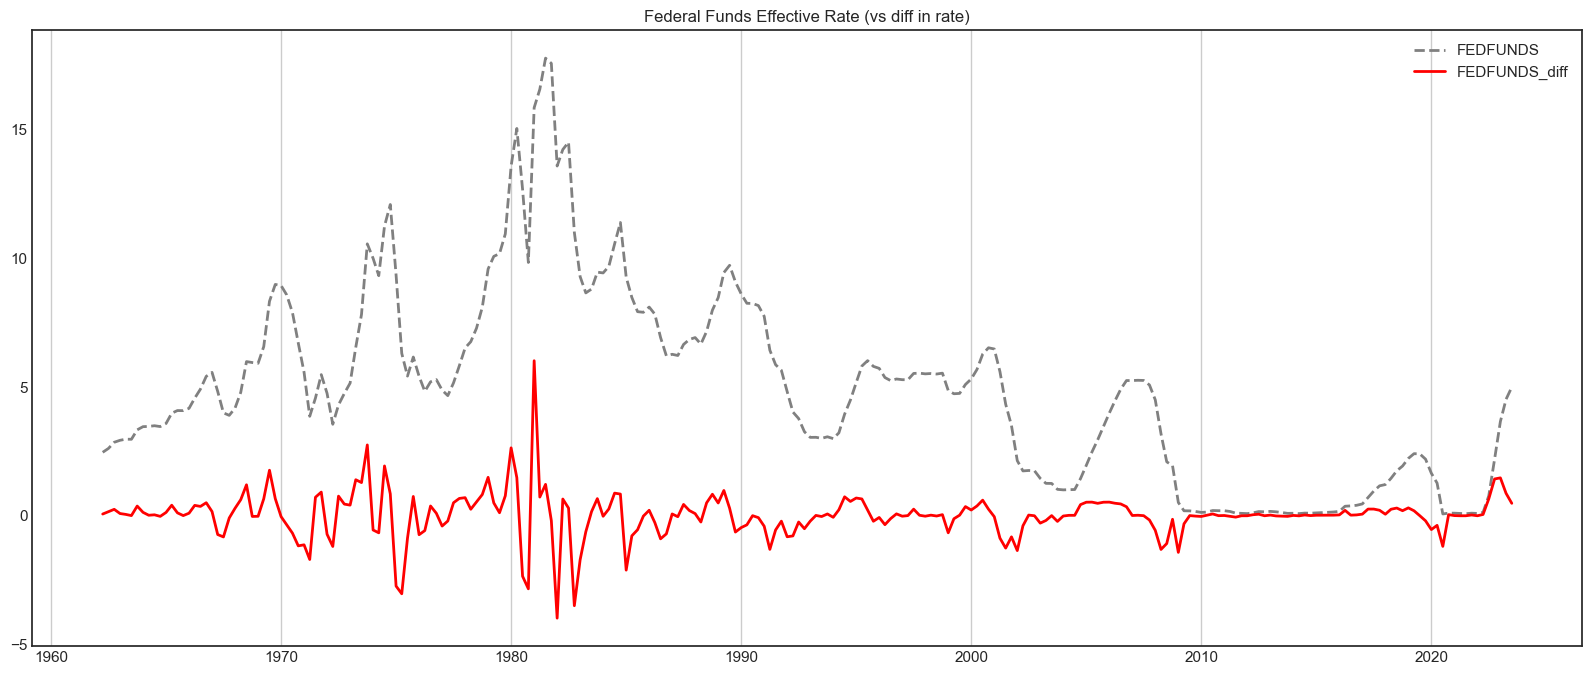

In [2715]:
# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid()

# Plot
ax.plot(taylor_df.index, taylor_df['FEDFUNDS'], 'gray', linestyle='--', linewidth=2)
ax.plot(taylor_df.index, taylor_df['FEDFUNDS_diff'], 'red', linewidth=2)
ax.legend(["FEDFUNDS","FEDFUNDS_diff"])
ax.set(title='Federal Funds Effective Rate (vs diff in rate)');
plt.show()

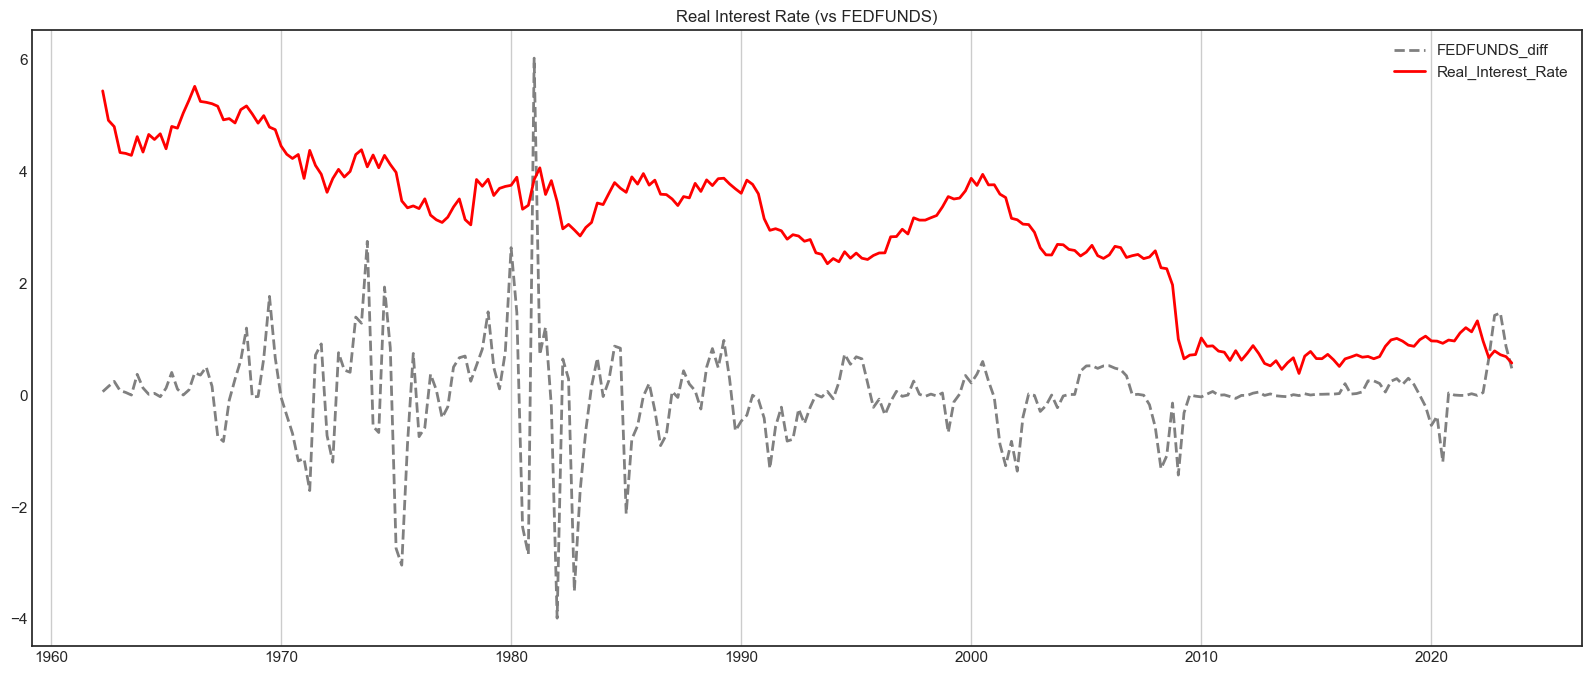

In [2716]:
# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid()

# Plot
ax.plot(taylor_df.index, taylor_df['FEDFUNDS_diff'], 'gray', linestyle='--', linewidth=2)
ax.plot(taylor_df.index, taylor_df['Real_Interest_Rate'], 'red', linewidth=2)
ax.legend(["FEDFUNDS_diff","Real_Interest_Rate"])
ax.set(title='Real Interest Rate (vs FEDFUNDS)');
plt.show()

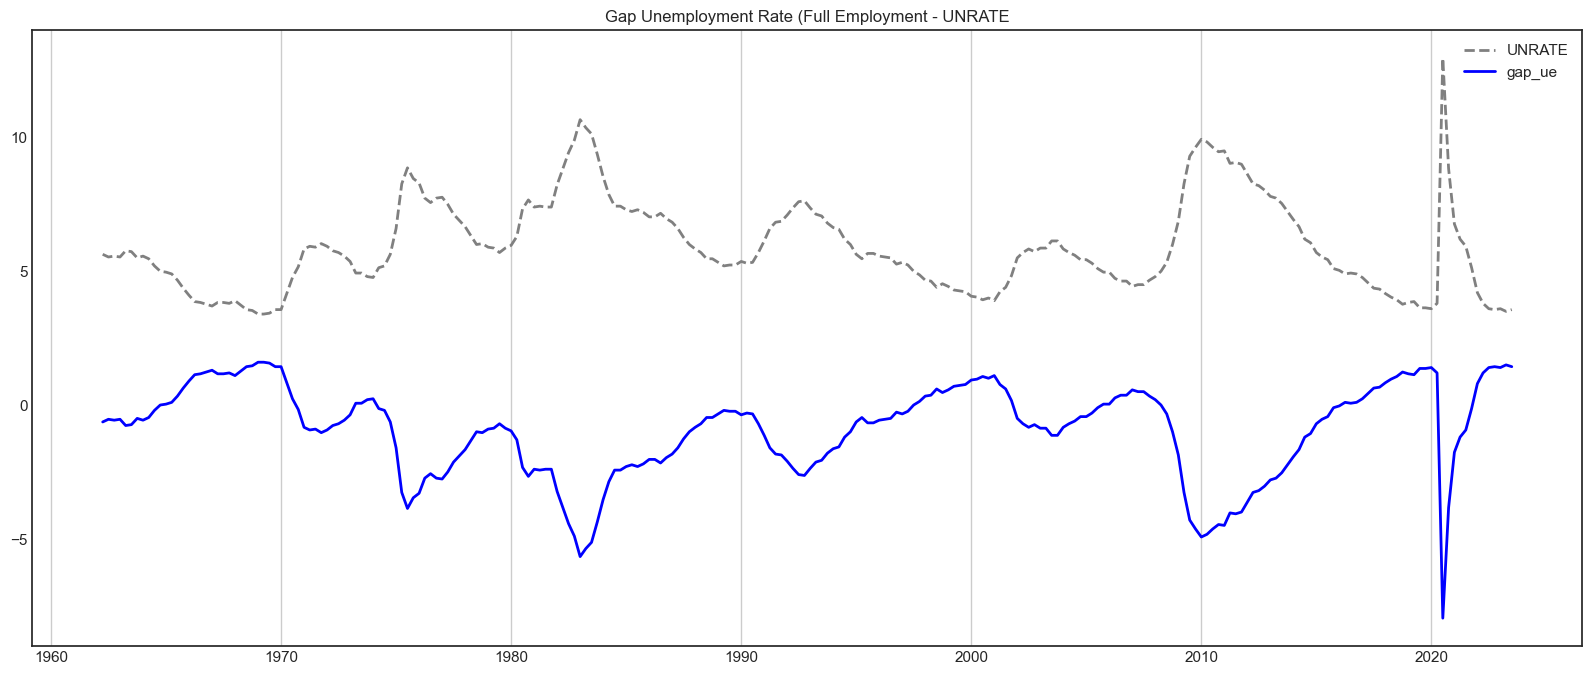

In [2717]:
# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid()

# Plot
ax.plot(taylor_df.index, taylor_df['UNRATE'], 'gray', linestyle='--', linewidth=2)
ax.plot(taylor_df.index, taylor_df['gap_ue'], 'blue', linewidth=2)
ax.legend(["UNRATE","gap_ue"])
ax.set(title='Gap Unemployment Rate (Full Employment - UNRATE');
plt.show()

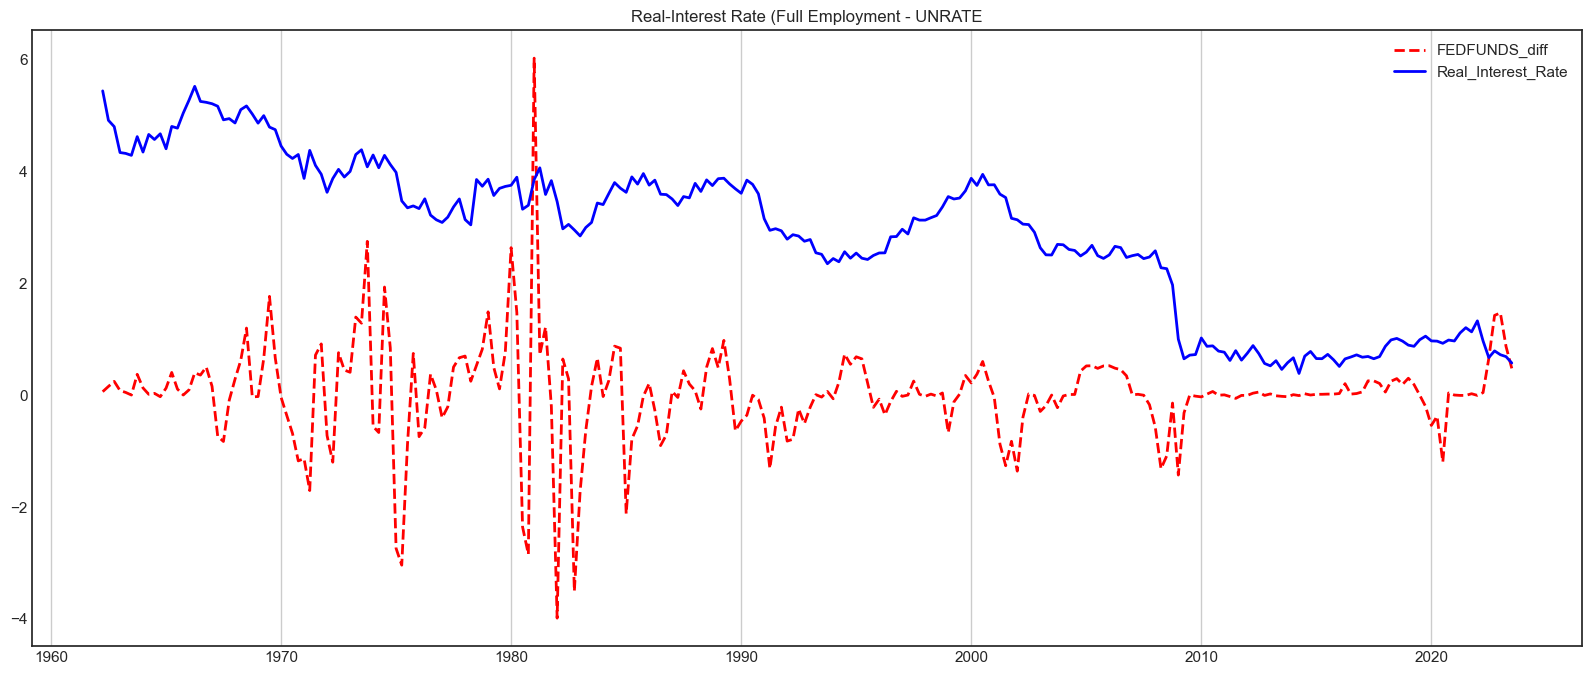

In [2718]:
# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid()

# Plot
ax.plot(taylor_df.index, taylor_df['FEDFUNDS_diff'], 'red', linestyle='--', linewidth=2)
ax.plot(taylor_df.index, taylor_df['Real_Interest_Rate'], 'blue', linewidth=2)
ax.legend(["FEDFUNDS_diff","Real_Interest_Rate"])
ax.set(title='Real-Interest Rate (Full Employment - UNRATE');
plt.show()

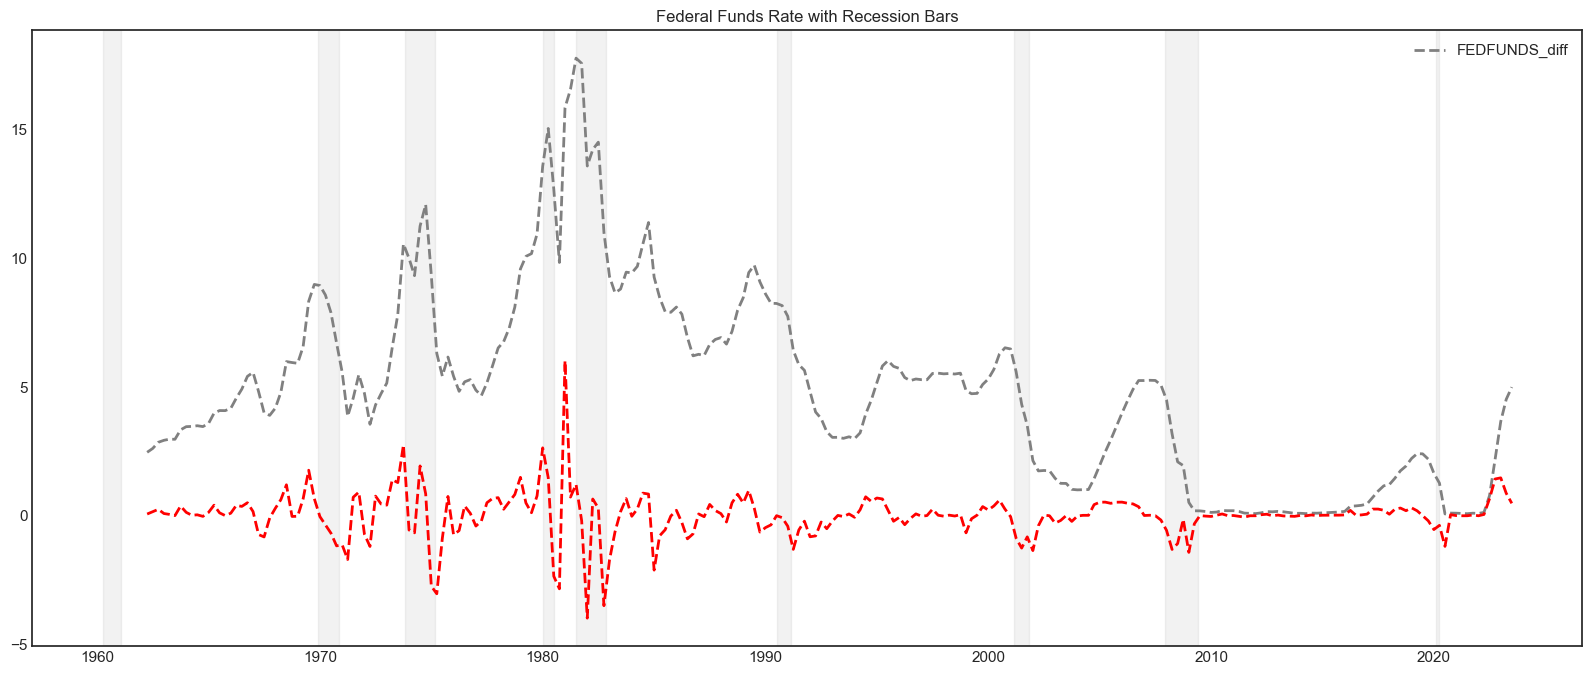

In [2719]:
cycol = cycle('rgbcmyk')


t_df = taylor_df.query('DATE >= "1960-01-01"')
r_df = get_recession()
r_df = r_df.query('Peak_Date >= "1960-01-01"')

# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid(False)

# Plot
ax.plot(taylor_df.index, taylor_df['FEDFUNDS'], 'gray', linestyle='--', linewidth=2)
ax.plot(t_df.index, t_df['FEDFUNDS_diff'], linestyle='--', color='red',linewidth=2)

# Plotting recession bars
for i,row in r_df.iterrows():
    plt.axvspan(row['Peak_Date'], row['Trough_Date'], color='gray', alpha=0.1)
   
ax.legend(["FEDFUNDS_diff"])
ax.set(title='Federal Funds Rate with Recession Bars');
plt.show()

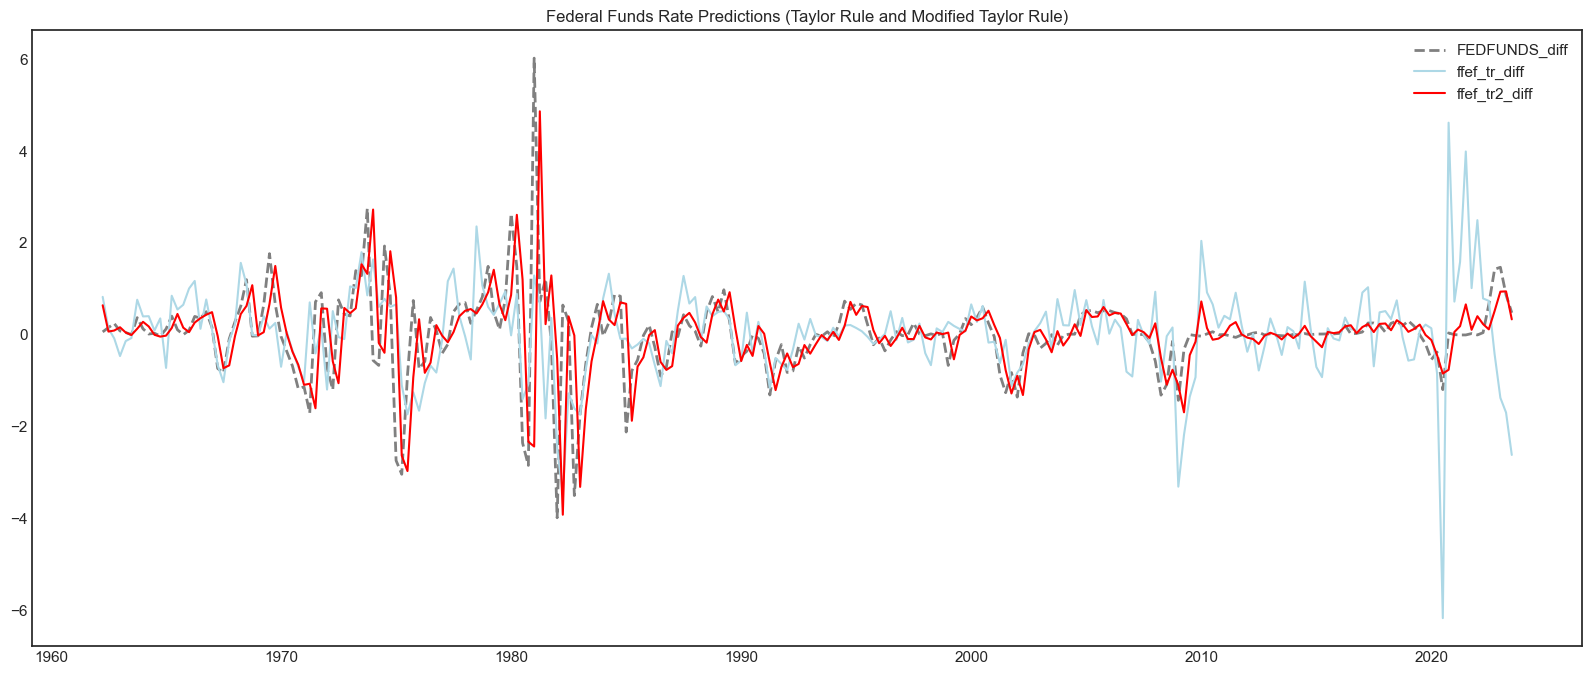

In [2720]:
# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid(False)

# Plo3
ax.plot(taylor_df.index, taylor_df['FEDFUNDS_diff'], 'gray', linestyle='--', linewidth=2)
ax.plot(taylor_df.index, taylor_df['ffef_tr_diff'], color='lightblue', linewidth=1.5)
ax.plot(taylor_df.index, taylor_df['ffef_tr2_diff'], color='red', linewidth=1.5)

ax.legend(["FEDFUNDS_diff", "ffef_tr_diff","ffef_tr2_diff"])
ax.set(title='Federal Funds Rate Predictions (Taylor Rule and Modified Taylor Rule)');

plt.show()

# Case

In [2721]:
#test_df[['FEDFUNDS-1', 'gap_inf', 'gap_ue','gap_gdp','recession_flag', 'CPIAUCSL_PC1']]

In [2722]:
case = 1  # Full Model
#case = 2  # Modified Taylor Rule
#case = 3  # Recession Model
#case = 4  # Simple Model
#case = 5  # Recession Model
#case = 6  # Full Model
#case = None  # Feature Selection

# Initialize Variables
X_train = None
y_train = None
X_test = None
y_test = None

# Initialize Imputer
preprocessor = None




if case == 1:
    
    print('-- Full Model (Lasso Base)')
    #X_train = train_df[['FEDFUNDS-1', 'gap_inf', 'gap_gdp','recession_flag', 'CPIAUCSL_PC1']]
    X_train = train_df[['gap_inf', 'gap_gdp','recession_flag']]
    y_train = train_df['FEDFUNDS_diff']


    #X_test = test_df[['FEDFUNDS-1', 'gap_inf', 'gap_gdp','recession_flag', 'CPIAUCSL_PC1']]
    X_test = test_df[[ 'gap_inf', 'gap_gdp','recession_flag']]
    y_test = test_df['FEDFUNDS_diff']

    # Initialize Imputer
    imp_num = SimpleImputer(missing_values=np.nan, strategy='mean')
    scaler_num = RobustScaler()
    #scaler_num = StandardScaler()
    #scaler_num = Normalizer()
    #scaler_num = PowerTransformer()

    # Initialize Transformer / OneHotEncoder
    cat_columns_lst = ['recession_flag']
    #num_columns_lst = ['FEDFUNDS-1','gap_inf', 'gap_gdp','CPIAUCSL_PC1']
    num_columns_lst = ['gap_inf', 'gap_gdp']


    ohe_categories = list()
    for c in cat_columns_lst:
        ohe_categories.append(list(X_train[c].unique()))

    ohe = OneHotEncoder(categories=ohe_categories, drop='first',
                       sparse_output=False, handle_unknown='ignore')

    transformer = make_column_transformer((ohe, cat_columns_lst), remainder='drop')

    
    #numeric_transformer = Pipeline(steps = [('imp_num',imp_num)])
    numeric_transformer = Pipeline(steps = [('scaler_num',scaler_num),('imp_num',imp_num)])
    categorical_transformer = Pipeline( steps=[('transformer',transformer)])


    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, num_columns_lst),
            ("cat", categorical_transformer, cat_columns_lst),
        ]
    )
    
elif case == 2:
    
    print('-- Modified Taylor Rule')
    X_train = train_df[['FEDFUNDS-1', 'gap_inf', 'gap_ue','Real_Interest_Rate']]
    #X_train = train_df[['gap_inf', 'gap_ue','Real_Interest_Rate']]
    y_train = train_df['FEDFUNDS_diff']


    X_test = test_df[['FEDFUNDS-1', 'gap_inf', 'gap_ue','Real_Interest_Rate']]
    #X_test = test_df[['gap_inf', 'gap_ue','Real_Interest_Rate']]
    y_test = test_df['FEDFUNDS_diff']


    # Initialize Imputer
    imp_num = SimpleImputer(missing_values=np.nan, strategy='mean')
    scaler_num = RobustScaler()
    #scaler_num = StandardScaler()
    #scaler_num = Normalizer()
    #scaler_num = PowerTransformer()

    # Initialize Transformer / OneHotEncoder
    num_columns_lst = ['FEDFUNDS-1', 'gap_inf', 'gap_ue','Real_Interest_Rate']
    #num_columns_lst = ['gap_inf', 'gap_ue','Real_Interest_Rate']
    #numeric_transformer = Pipeline(steps = [('imp_num',imp_num)])
    numeric_transformer = Pipeline(steps = [('scaler_num',scaler_num),('imp_num',imp_num)])

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, num_columns_lst),
        ]
    )
    
    
    
elif case == 3:
    print('-- Recession Model')
    X_train = train_df[['gap_inf', 'gap_ue','recession_flag','FEDFUNDS-1','Real_Interest_Rate']]
    y_train = train_df['FEDFUNDS_diff']


    X_test = test_df[['gap_inf', 'gap_ue','recession_flag','FEDFUNDS-1','Real_Interest_Rate']]
    y_test = test_df['FEDFUNDS_diff']


    # Initialize Imputer
    imp_num = SimpleImputer(missing_values=np.nan, strategy='mean')
    scaler_num = RobustScaler()
    #scaler_num = StandardScaler()
    #scaler_num = Normalizer()
    #scaler_num = PowerTransformer()

    # Initialize Transformer / OneHotEncoder
    cat_columns_lst = ['recession_flag']
    num_columns_lst = ['gap_inf', 'gap_ue','FEDFUNDS-1','Real_Interest_Rate']


    ohe_categories = list()
    for c in cat_columns_lst:
        ohe_categories.append(list(X_train[c].unique()))

    ohe = OneHotEncoder(categories=ohe_categories, drop='first',
                       sparse_output=False, handle_unknown='ignore')

    transformer = make_column_transformer((ohe, cat_columns_lst), remainder='drop')


    #numeric_transformer = Pipeline(steps = [('imp_num',imp_num)])
    numeric_transformer = Pipeline(steps = [('scaler_num',scaler_num),('imp_num',imp_num)])
    categorical_transformer = Pipeline( steps=[('transformer',transformer)])


    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, num_columns_lst),
            ("cat", categorical_transformer, cat_columns_lst),
        ]
    )

elif case == 4:
    print('-- Simplified Model')
    X_train = train_df[['FEDFUNDS-1', 'gap_inf', 'gap_ue']]
    y_train = train_df['FEDFUNDS_diff']


    X_test = test_df[['FEDFUNDS-1', 'gap_inf', 'gap_ue']]
    y_test = test_df['FEDFUNDS_diff']


    # Initialize Imputer
    imp_num = SimpleImputer(missing_values=np.nan, strategy='mean')
    #scaler_num = RobustScaler()
    #scaler_num = StandardScaler()
    #scaler_num = Normalizer()
    #scaler_num = PowerTransformer()

    # Initialize Transformer / OneHotEncoder
    num_columns_lst = ['FEDFUNDS-1', 'gap_inf', 'gap_ue']
    #numeric_transformer = Pipeline(steps = [('imp_num',imp_num)])
    numeric_transformer = Pipeline(steps = [('scaler_num',scaler_num),('imp_num',imp_num)])

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, num_columns_lst),
        ]
    )

    
elif case == 5:
    print('-- Recession Model (minus Real Interest Rates)')
    X_train = train_df[['gap_inf', 'gap_ue','recession_flag','FEDFUNDS-1']]
    y_train = train_df['FEDFUNDS_diff']


    X_test = test_df[['gap_inf', 'gap_ue','recession_flag','FEDFUNDS-1']]
    y_test = test_df['FEDFUNDS_diff']


    # Initialize Imputer
    imp_num = SimpleImputer(missing_values=np.nan, strategy='mean')
    scaler_num = RobustScaler()
    #scaler_num = StandardScaler()
    #scaler_num = Normalizer()
    #scaler_num = PowerTransformer()

    # Initialize Transformer / OneHotEncoder
    cat_columns_lst = ['recession_flag']
    num_columns_lst = ['gap_inf', 'gap_ue','FEDFUNDS-1']


    ohe_categories = list()
    for c in cat_columns_lst:
        ohe_categories.append(list(X_train[c].unique()))

    ohe = OneHotEncoder(categories=ohe_categories, drop='first',
                       sparse_output=False, handle_unknown='ignore')

    transformer = make_column_transformer((ohe, cat_columns_lst), remainder='drop')


    #numeric_transformer = Pipeline(steps = [('imp_num',imp_num)])
    numeric_transformer = Pipeline(steps = [('scaler_num',scaler_num),('imp_num',imp_num)])
    categorical_transformer = Pipeline( steps=[('transformer',transformer)])


    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, num_columns_lst),
            ("cat", categorical_transformer, cat_columns_lst),
        ]
    )
    
elif case == 6:
    print('-- Feature Selection')
    X_train = train_df[['gap_inf', 'gap_gdp','Real_Interest_Rate','recession_flag','FEDFUNDS-1']]
    y_train = train_df['FEDFUNDS_diff']


    X_test = test_df[['gap_inf', 'gap_gdp','Real_Interest_Rate','recession_flag','FEDFUNDS-1']]
    y_test = test_df['FEDFUNDS_diff']


    # Initialize Imputer
    imp_num = SimpleImputer(missing_values=np.nan, strategy='mean')
    scaler_num = RobustScaler()
    #scaler_num = StandardScaler()
    #scaler_num = Normalizer()
    #scaler_num = PowerTransformer()

    # Initialize Transformer / OneHotEncoder
    cat_columns_lst = ['recession_flag']
    num_columns_lst = ['gap_inf', 'gap_gdp','Real_Interest_Rate','FEDFUNDS-1']


    ohe_categories = list()
    for c in cat_columns_lst:
        ohe_categories.append(list(X_train[c].unique()))

    ohe = OneHotEncoder(categories=ohe_categories, drop='first',
                       sparse_output=False, handle_unknown='ignore')

    transformer = make_column_transformer((ohe, cat_columns_lst), remainder='drop')


    #numeric_transformer = Pipeline(steps = [('imp_num',imp_num)])
    numeric_transformer = Pipeline(steps = [('scaler_num',scaler_num),('imp_num',imp_num)])
    categorical_transformer = Pipeline( steps=[('transformer',transformer)])


    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, num_columns_lst),
            ("cat", categorical_transformer, cat_columns_lst),
        ]
    )

elif case == 7:
    print('-- All Variables')
    X_train = train_df[['gap_inf', 'gap_gdp','gap_ue','Real_Interest_Rate','CPIAUCSL_PC1','UNRATE','recession_flag','FEDFUNDS-1']]
    y_train = train_df['FEDFUNDS_diff']


    X_test = test_df[['gap_inf', 'gap_gdp','gap_ue','Real_Interest_Rate','CPIAUCSL_PC1','UNRATE','recession_flag','FEDFUNDS-1']]
    y_test = test_df['FEDFUNDS_diff']


    # Initialize Imputer
    imp_num = SimpleImputer(missing_values=np.nan, strategy='mean')
    scaler_num = RobustScaler()
    #scaler_num = StandardScaler()
    #scaler_num = Normalizer()
    #scaler_num = PowerTransformer()

    # Initialize Transformer / OneHotEncoder
    cat_columns_lst = ['recession_flag']
    num_columns_lst = ['gap_inf', 'gap_gdp','gap_ue','Real_Interest_Rate','CPIAUCSL_PC1','UNRATE','FEDFUNDS-1']


    ohe_categories = list()
    for c in cat_columns_lst:
        ohe_categories.append(list(X_train[c].unique()))

    ohe = OneHotEncoder(categories=ohe_categories, drop='first',
                       sparse_output=False, handle_unknown='ignore')

    transformer = make_column_transformer((ohe, cat_columns_lst), remainder='drop')


    #numeric_transformer = Pipeline(steps = [('imp_num',imp_num)])
    numeric_transformer = Pipeline(steps = [('scaler_num',scaler_num),('imp_num',imp_num)])
    categorical_transformer = Pipeline( steps=[('transformer',transformer)])


    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, num_columns_lst),
            ("cat", categorical_transformer, cat_columns_lst),
        ]
    )  
    
else:
    print('-- All Variables')
    X_train = train_df[['gap_inf', 'gap_gdp','gap_ue','Real_Interest_Rate','CPIAUCSL_PC1','UNRATE','recession_flag','FEDFUNDS-1']]
    y_train = train_df['FEDFUNDS_diff']


    X_test = test_df[['gap_inf', 'gap_gdp','gap_ue','Real_Interest_Rate','CPIAUCSL_PC1','UNRATE','recession_flag','FEDFUNDS-1']]
    y_test = test_df['FEDFUNDS_diff']


    # Initialize Imputer
    imp_num = SimpleImputer(missing_values=np.nan, strategy='mean')
    scaler_num = RobustScaler()
    #scaler_num = StandardScaler()
    #scaler_num = Normalizer()
    #scaler_num = PowerTransformer()

    # Initialize Transformer / OneHotEncoder
    cat_columns_lst = ['recession_flag']
    num_columns_lst = ['gap_inf', 'gap_gdp','gap_ue','Real_Interest_Rate','CPIAUCSL_PC1','UNRATE','FEDFUNDS-1']


    ohe_categories = list()
    for c in cat_columns_lst:
        ohe_categories.append(list(X_train[c].unique()))

    ohe = OneHotEncoder(categories=ohe_categories, drop='first',
                       sparse_output=False, handle_unknown='ignore')

    transformer = make_column_transformer((ohe, cat_columns_lst), remainder='drop')


    #numeric_transformer = Pipeline(steps = [('imp_num',imp_num)])
    numeric_transformer = Pipeline(steps = [('scaler_num',scaler_num),('imp_num',imp_num)])
    categorical_transformer = Pipeline( steps=[('transformer',transformer)])


    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, num_columns_lst),
            ("cat", categorical_transformer, cat_columns_lst),
        ]
    )    


-- Full Model (Lasso Base)


In [2723]:
t_fit = preprocessor.fit(X_train)
t_fit.get_feature_names_out()
X_train_trf = t_fit.transform(X_train)

#X_train_trf.columns = 
X_train_trf = pd.DataFrame(X_train_trf)
feature_names = t_fit.get_feature_names_out()
X_train_trf.columns = feature_names
X_train_trf['DATE'] = y_train.index
X_train_trf.set_index('DATE', inplace=True)

print('X_train_trf: ', X_train_trf.shape)



X_train_trf:  (197, 3)


# Stats Model - OLS

In [2724]:
X_train_const = sm.add_constant(X_train_trf)

In [2725]:
ols_model = sm.OLS(y_train, X_train_const)
ols_result = ols_model.fit()

ols_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          FEDFUNDS_diff   R-squared:                       0.204
Model:                            OLS   Adj. R-squared:                  0.192
Method:                 Least Squares   F-statistic:                     16.54
Date:                Tue, 28 Nov 2023   Prob (F-statistic):           1.33e-09
Time:                        00:36:26   Log-Likelihood:                -250.57
No. Observations:                 197   AIC:                             509.1
Df Residuals:                     193   BIC:                             522.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===========================================================================================================
                                              coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
const                                       0.0486      0.068      0.717      0.474      -0.085       0.182
num__gap_inf                                0.1838      0.066      2.799      0.006       0.054       0.313
num__gap_gdp                                0.3462      0.074      4.665      0.000       0.200       0.492
cat__onehotencoder__recession_flag_True    -0.8937      0.197     -4.545      0.000      -1.282      -0.506
==============================================================================
Omnibus:                       58.335   Durbin-Watson:                   1.852
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              880.299
Skew:                           0.589   Prob(JB):                    7.01e-192
Kurtosis:                      13.289   Cond. No.                         3.81
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [2726]:
train_pred = ols_result.predict(X_train_const)

t = ols_result.get_prediction(X_train_const)
train_pred_ols = t.summary_frame(alpha=0.05)

In [2727]:
model_stats_df = model_results('ols_train', y_train, train_pred_ols['mean'], X_train.shape[0], X_train.shape[1] , model_stats_df )

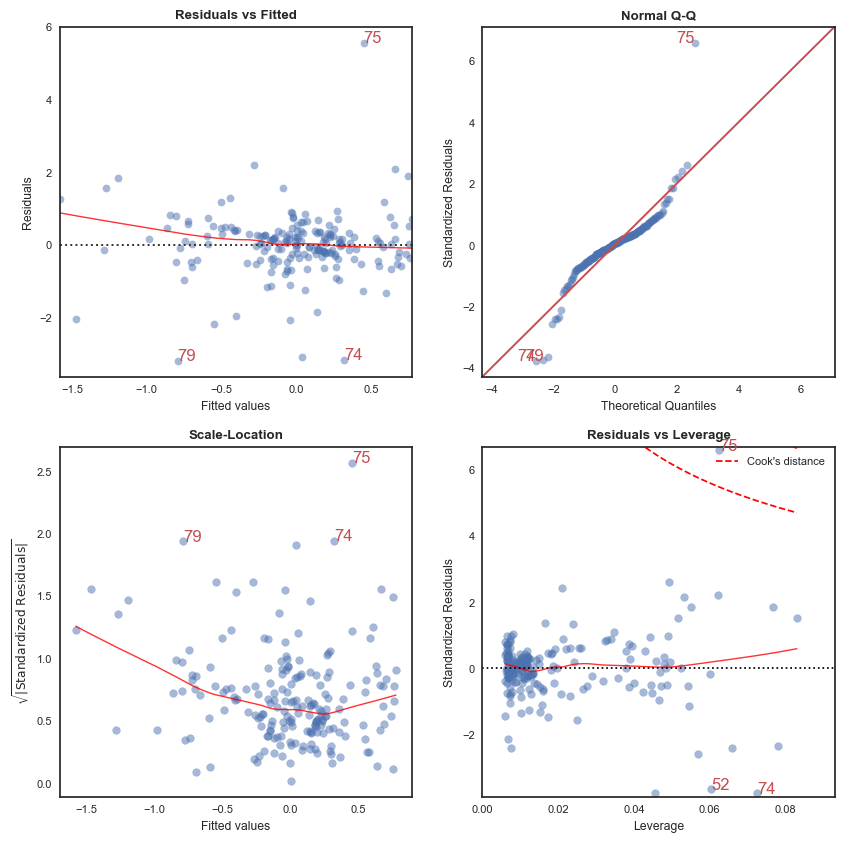

                                  Features  VIF Factor
0                                    const    1.190858
1                             num__gap_inf    1.163879
2                             num__gap_gdp    1.026666
3  cat__onehotencoder__recession_flag_True    1.184277


In [2728]:
cls = LinearRegDiagnostic(ols_result)
vif, fig, ax = cls()
print(vif)

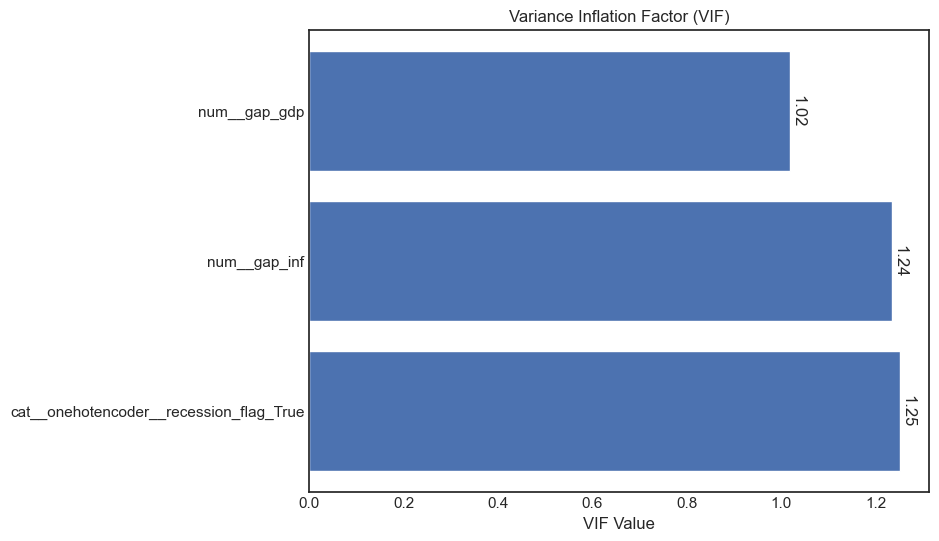

In [2729]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame()
vif_data["Variable"] = X_train_trf.columns
vif_data["VIF"] = [variance_inflation_factor(X_train_trf.values, i) for i in range(X_train_trf.shape[1])]


# Sort the VIF values for plotting
vif_data_sorted = vif_data.sort_values(by="VIF", ascending=False)

# Create a bar plot for VIF values
plt.figure(figsize=(8, 6))
plt.barh(vif_data_sorted['Variable'], vif_data_sorted['VIF'])

# Add vertical labels to the bars
for i, value in enumerate(vif_data_sorted['VIF']):
    plt.text(value, i, f'{value:.2f}', va='center', ha='left', rotation=-90)
    
plt.xlabel('VIF Value')
plt.title('Variance Inflation Factor (VIF)')
plt.show()

In [2730]:
# Get the residuals from the fitted model
residuals = ols_result.resid

# Perform Shapiro-Wilk test for normality
shapiro_test = shapiro(residuals)

# Display the Shapiro-Wilk test statistic and p-value
print("Shapiro-Wilk Test Statistic:", shapiro_test.statistic)
print("Shapiro-Wilk p-value:", round(shapiro_test.pvalue,6))

Shapiro-Wilk Test Statistic: 0.8491141200065613
Shapiro-Wilk p-value: 0.0


In [2731]:
# White's Test: A significant p-value suggests the presence of heteroscedasticity.

white_test = het_white(ols_result.resid,  ols_result.model.exog)

labels = ['Test Statistic', 'Test Statistic p-value', 'F-Statistic', 'F-Test p-value']
wt_df = pd.DataFrame(zip(labels, white_test))
wt_df.columns = ['name', 'value']
round(wt_df,4)

name    value
0          Test Statistic  74.7405
1  Test Statistic p-value   0.0000
2             F-Statistic  14.3662
3          F-Test p-value   0.0000

## Test

In [2732]:
X_test_trf = t_fit.transform(X_test)

X_test_trf = pd.DataFrame(X_test_trf)
X_test_trf.columns = t_fit.get_feature_names_out()
X_test_trf['DATE'] = y_test.index
X_test_trf.set_index('DATE', inplace=True)

X_test_const = sm.add_constant(X_test_trf)
print('X_test_const: ', X_test_const.shape)

X_test_const:  (49, 4)


In [2733]:
t = ols_result.get_prediction(X_test_const)
test_pred_ols = t.summary_frame(alpha=0.05)
test_pred_ols.shape

(49, 6)

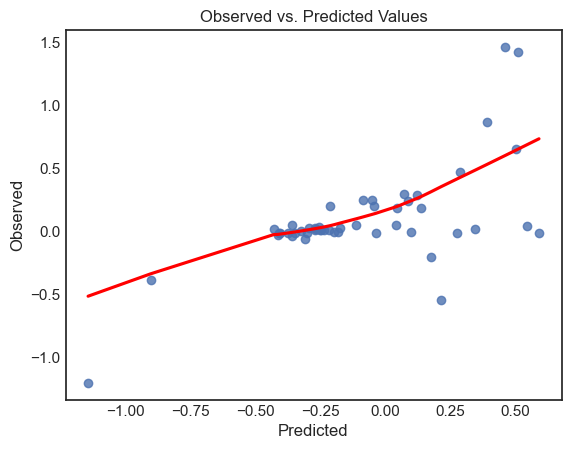

In [2734]:
fitted_vals = test_pred_ols['mean']
resids = y_test - test_pred_ols['mean']


fig, ax = plt.subplots(1)

sns.regplot(x=fitted_vals, y=y_test, lowess=True, ax=ax, line_kws={'color': 'red'})
ax.set_title('Observed vs. Predicted Values', fontsize=12)
ax.set(xlabel='Predicted', ylabel='Observed')

plt.show()

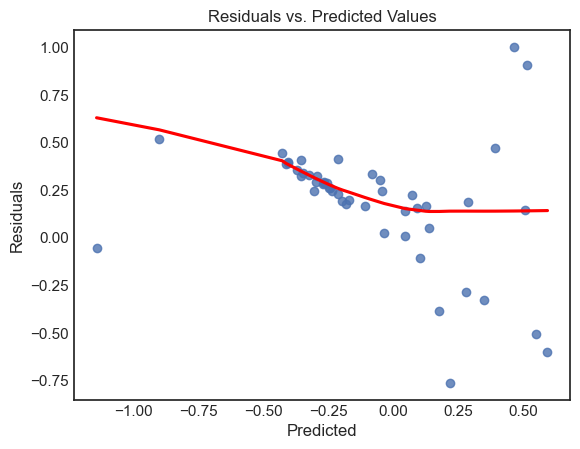

In [2735]:
fig, ax = plt.subplots(1)
sns.regplot(x=fitted_vals, y=resids, lowess=True, ax=ax, line_kws={'color': 'red'})
ax.set_title('Residuals vs. Predicted Values', fontsize=12)
ax.set(xlabel='Predicted', ylabel='Residuals')

plt.show()

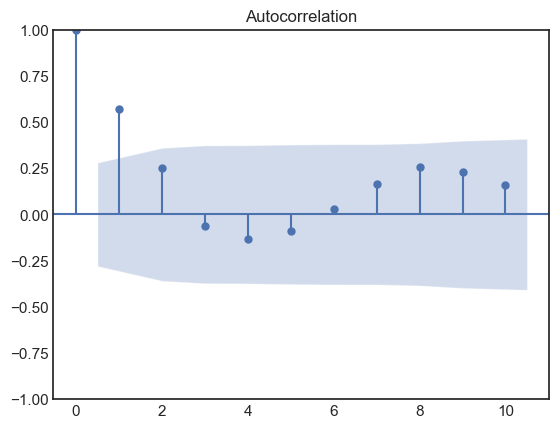

In [2736]:
acf = smt.graphics.plot_acf(resids, lags=10 , alpha=0.05)
acf.show()

In [2737]:
model_stats_df = model_results('ols_test', y_test, test_pred_ols['mean'], X_test.shape[0], X_test.shape[1] , model_stats_df )

# Generalized Linear Model

In [2738]:
X_train_const = sm.add_constant(X_train_trf)

In [2739]:
#glm_model = sm.GLM(y_train, X_train_const, family=sm.families.Gaussian(link=sm.families.links.log()))
glm_model = sm.GLM(y_train, X_train_const, family=sm.families.Gaussian(link=sm.families.links.inverse_power()))

glm_result = glm_model.fit(attach_wls=True,atol=1e-10)

glm_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:          FEDFUNDS_diff   No. Observations:                  197
Model:                            GLM   Df Residuals:                      193
Model Family:                Gaussian   Df Model:                            3
Link Function:          inverse_power   Scale:                         0.93618
Method:                          IRLS   Log-Likelihood:                -271.03
Date:                Tue, 28 Nov 2023   Deviance:                       180.68
Time:                        00:36:26   Pearson chi2:                     181.
No. Iterations:                   100   Pseudo R-squ. (CS):            0.02077
Covariance Type:            nonrobust                                         
===========================================================================================================
                                              coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
const                                      47.5888    107.089      0.444      0.657    -162.302     257.480
num__gap_inf                               -4.6293     16.332     -0.283      0.777     -36.640      27.381
num__gap_gdp                               12.4215     40.106      0.310      0.757     -66.184      91.027
cat__onehotencoder__recession_flag_True   -51.1472    114.656     -0.446      0.656    -275.869     173.574
===========================================================================================================
"""

infl = glm_result.get_influence(observed=False)

summ_df = infl.summary_frame()
#summ_df.sort_values("cooks_d", ascending=False)[:10]

fig = infl.plot_influence()
fig.tight_layout(pad=1.0)

plt.show()

In [2740]:
train_pred_glm = glm_result.predict(X_train_const)

t = glm_result.get_prediction(X_train_const)
train_pred_glm = t.summary_frame(alpha=0.05)

In [2741]:
model_stats_df = model_results('glm_train', y_train, train_pred_glm['mean'], X_train.shape[0], X_train.shape[1] , model_stats_df )

## Test

In [2742]:
X_test_trf = t_fit.transform(X_test)

X_test_trf = pd.DataFrame(X_test_trf)
X_test_trf.columns = t_fit.get_feature_names_out()
X_test_trf['DATE'] = y_test.index
X_test_trf.set_index('DATE', inplace=True)

X_test_const = sm.add_constant(X_test_trf)
print('X_test_const: ', X_test_const.shape)

X_test_const:  (49, 4)


In [2743]:
t = glm_result.get_prediction(X_test_const)
test_pred_glm = t.summary_frame(alpha=0.05)
test_pred_glm.shape

(49, 4)

In [2744]:
model_stats_df = model_results('glm_test', y_test, test_pred_glm['mean'], X_test.shape[0], X_test.shape[1] , model_stats_df )
model_stats_df

name     r_sq  adj_r_sq     mse    rmse
0   ffef_tr_train   0.0328    0.0279  0.9061  0.9519
1    ffef_tr_test -13.6332  -13.9446  2.2484  1.4995
2  ffef_tr2_train  -0.3337   -0.3406  1.2494  1.1178
3   ffef_tr2_test   0.5059    0.4954  0.0759  0.2755
4     Naive_train  -0.0001   -0.0001  0.9369  0.9680
5      Naive_test  -0.0633   -0.0633  0.1634  0.4042
6       ols_train   0.2045    0.1963  0.7453  0.8633
7        ols_test   0.1064    0.0675  0.1373  0.3705
8       glm_train   0.0210    0.0109  0.9172  0.9577
9        glm_test  -0.1173   -0.1659  0.1717  0.4143

# Lasso

In [2745]:
# Lasso with 5 fold cross-validation
model = linear_model.LassoCV(cv=5, random_state=rand_int, max_iter=10000)

# Fit model
model.fit(X_train_trf, y_train)

print('model.alpha_: ', model.alpha_)

model.alpha_:  0.000276338526445487


In [2746]:
pipe_lasso = Pipeline(
    steps = [ ('preprocessor',preprocessor), ('model',linear_model.LassoCV(cv=5, 
                                                                           #alphas=[0.001, 0.01,0.05, 0.1, 0.5],
                                                                           random_state=rand_int, 
                                                                           max_iter=10000))]
)

param_lasso = {
    #'model__alpha': [0.01, 0.05, 0.1, 0.5],
    'model__verbose': [0],
}


cv = RandomizedSearchCV(estimator = pipe_lasso, 
                        param_distributions = param_lasso,
                        random_state=rand_int, 
                        scoring="r2")

cv.fit(X_train, y_train)
cv_results = cv.cv_results_['mean_test_score']
print('Lasso', ') Best Accuracy Score:' , cv.best_score_ , 'Parameters: {}' , cv.best_params_)

Lasso ) Best Accuracy Score: 0.06055860890644445 Parameters: {} {'model__verbose': 0}


In [2747]:
lasso_best = linear_model.Lasso(alpha=cv.best_estimator_.named_steps.model.alpha_)
lasso_best.fit(X_train_trf, y_train)

train_pred_lasso = lasso_best.predict(X_train_trf)

In [2748]:
feature_df = pd.DataFrame(lasso_best.coef_, t_fit.get_feature_names_out())
feature_df.columns = ['coef']
feature_df.sort_values(by=['coef'], key=pd.Series.abs , ascending=False , inplace=True)
feature_df

coef
cat__onehotencoder__recession_flag_True -0.890742
num__gap_gdp                             0.345890
num__gap_inf                             0.183109

In [2749]:
feature_df.index

Index(['cat__onehotencoder__recession_flag_True', 'num__gap_gdp',
       'num__gap_inf'],
      dtype='object')

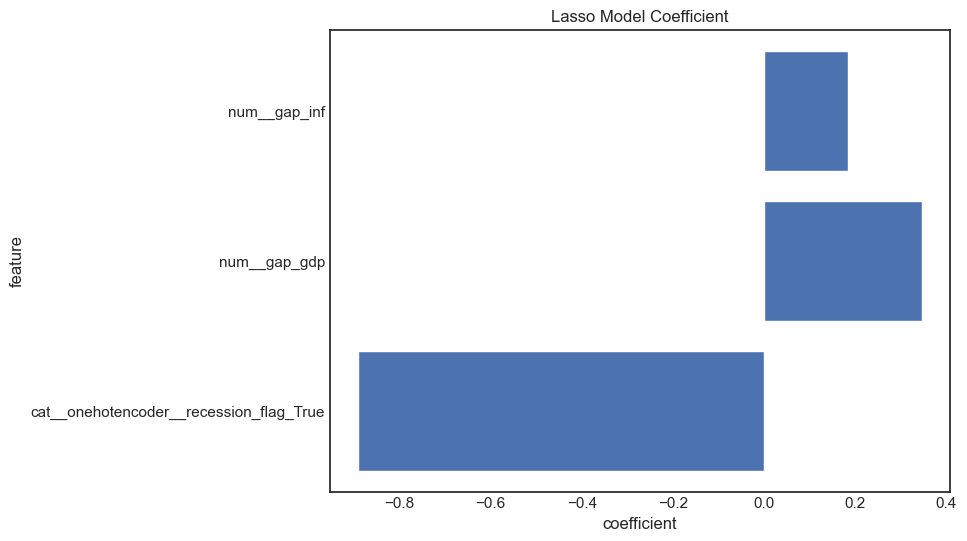

In [2750]:
# Plot the MSE values against alphas
plt.figure(figsize=(8, 6))
plt.barh(feature_df.index, feature_df['coef'])

#plt.legend()
plt.xlabel('coefficient')
plt.ylabel('feature')
plt.title('Lasso Model Coefficient')
plt.grid(False)
plt.show()

### linearity assumption Interpretation:
Ideally, the scatter plot should show a strong linear relationship along the diagonal line (y = x). This indicates that the model's predictions are close to the actual values.
A scattered or disperse pattern away from the diagonal line might indicate areas where the model performs poorly, potentially highlighting non-linearity or other issues in the model.

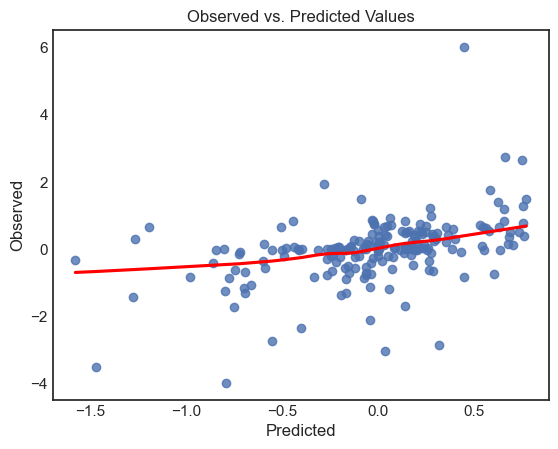

In [2751]:
fig, ax = plt.subplots(1)

sns.regplot(x=train_pred_lasso, y=y_train, lowess=True, ax=ax, line_kws={'color': 'red'})
ax.set_title('Observed vs. Predicted Values', fontsize=12)
ax.set(xlabel='Predicted', ylabel='Observed')

plt.show()

### independence of residuals Iterpretation:
In the scatter plot(s), check for a consistent spread of residuals around zero. If the spread of residuals widens or narrows systematically as predicted values or predictor values change, it suggests heteroscedasticity, violating the assumption of homoscedasticity.

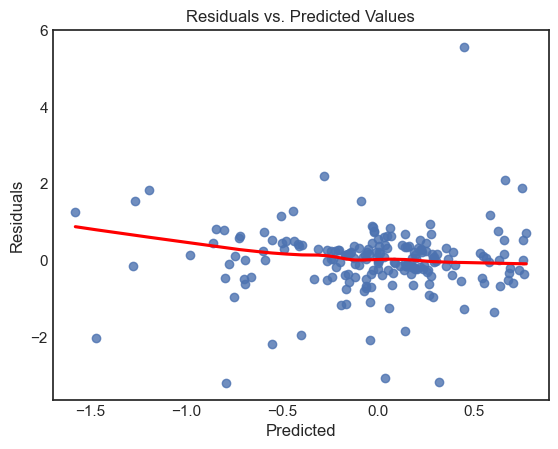

In [2848]:
# independence of residuals

residuals = y_train - train_pred_lasso

fig, ax = plt.subplots(1)

sns.regplot(x=train_pred_lasso, y=residuals, lowess=True, ax=ax, line_kws={'color': 'red'})
ax.set_title('Residuals vs. Predicted Values', fontsize=12)
ax.set(xlabel='Predicted', ylabel='Residuals')

plt.show()

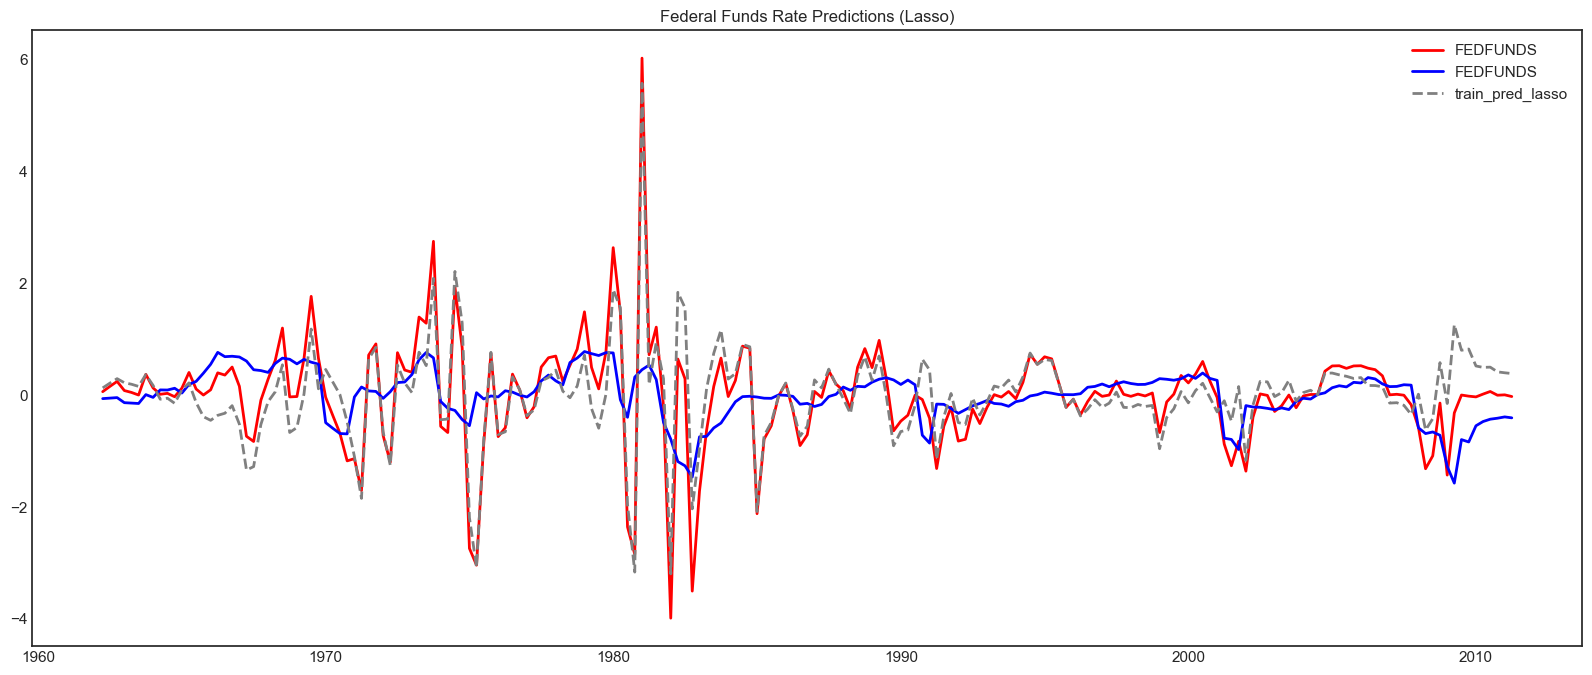

In [2855]:
# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid(False)

# Plot
ax.plot(y_train.index, y_train, 'lightgray', color='red',linewidth=2)
ax.plot(y_train.index, train_pred_lasso, 'lightgray', color='blue',linewidth=2)
ax.plot(y_train.index, residuals, 'lightgray', linestyle="--",color='gray',linewidth=2)


ax.legend(["FEDFUNDS", "FEDFUNDS","train_pred_lasso","test_pred_lasso"])
ax.set(title='Federal Funds Rate Predictions (Lasso)');

plt.show()

In [2753]:
# values for durbin watson test is between 0 and 4 the value close to 2 is accurate
# Durbin-Watson Test: Provides a measure (statistic) that ranges from 0 to 4. A value around 2 
# suggests no autocorrelation. Values closer to 0 indicate positive autocorrelation, 
# while values near 4 suggest negative autocorrelation.

durbin_watson_stat = durbin_watson(residuals)
print("Durbin-Watson statistic:", durbin_watson_stat)

Durbin-Watson statistic: 1.851627211017176


In [2856]:
# Perform Shapiro-Wilk test for normality
shapiro_test = shapiro(residuals)

# p-value < 0.05 - reject the null hypothesis residuals are not normally distrivuted
# Display the Shapiro-Wilk test statistic and p-value
print("Shapiro-Wilk Test Statistic:", shapiro_test.statistic)
print("Shapiro-Wilk p-value:", round(shapiro_test.pvalue,8))


# Check for normality based on the p-value
alpha = 0.05  # Set a significance level
if shapiro_test.pvalue > alpha:
    print("Sample looks Gaussian (fail to reject H0 - data is normally distributed)")
else:
    print("Sample does not look Gaussian (reject H0 - data is not normally distributed)")

Shapiro-Wilk Test Statistic: 0.849025547504425
Shapiro-Wilk p-value: 0.0
Sample does not look Gaussian (reject H0 - data is not normally distributed)


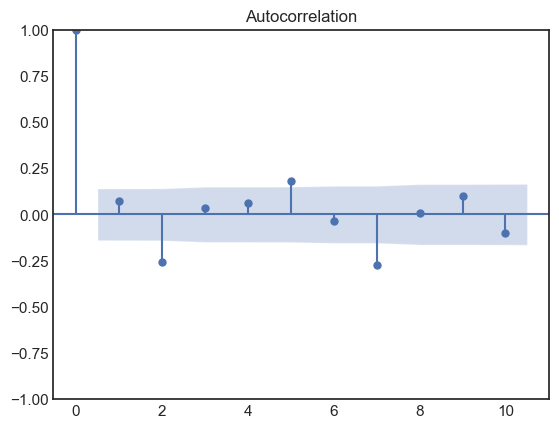

In [2755]:
acf = smt.graphics.plot_acf(residuals, lags=10 , alpha=0.05)
acf.show()

In [2756]:
model_stats_df = model_results('lasso_train', y_train, train_pred_lasso, X_train.shape[0], X_train.shape[1] , model_stats_df )

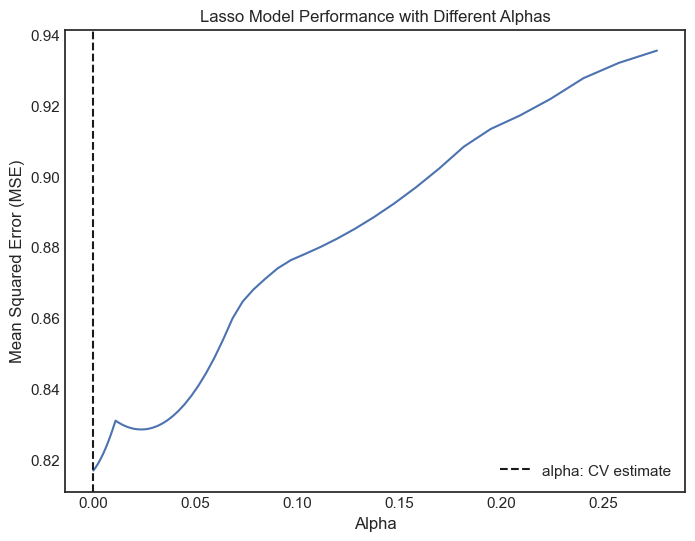

In [2757]:
mse_values = np.mean(model.mse_path_, axis=1)

# Plot the MSE values against alphas
plt.figure(figsize=(8, 6))
plt.plot(model.alphas_, mse_values)

plt.axvline(
    model.alpha_, linestyle="--", color="k", label="alpha: CV estimate"
)
plt.legend()
plt.xlabel('Alpha')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Lasso Model Performance with Different Alphas')
plt.grid(False)
plt.show()

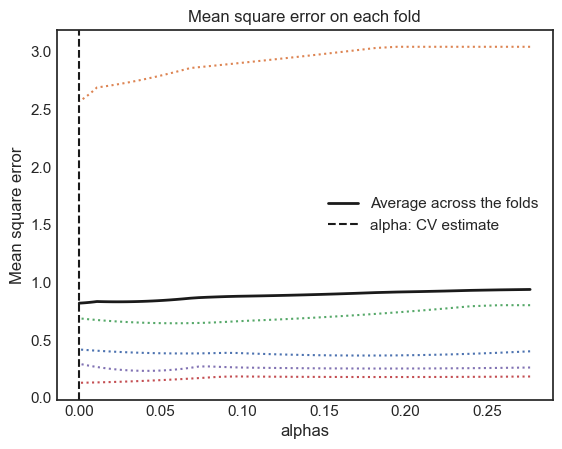

In [2758]:
#plt.semilogx(model.alphas_, model.mse_path_, ":")
plt.plot(model.alphas_, model.mse_path_, ":")
plt.plot(
    model.alphas_ ,
    model.mse_path_.mean(axis=-1),
    "k",
    label="Average across the folds",
    linewidth=2,
)
plt.axvline(
    model.alpha_, linestyle="--", color="k", label="alpha: CV estimate"
)

plt.legend()
plt.xlabel("alphas")
plt.ylabel("Mean square error")
plt.title("Mean square error on each fold")
plt.axis("tight")
plt.show()
#ymin, ymax = 50000, 250000
#plt.ylim(ymin, ymax);

## Test

In [2759]:
X_test_trf = t_fit.transform(X_test)

X_test_trf = pd.DataFrame(X_test_trf)
X_test_trf.columns = t_fit.get_feature_names_out()
X_test_trf['DATE'] = y_test.index
X_test_trf.set_index('DATE', inplace=True)

print('X_test_const: ', X_test_trf.shape)

X_test_const:  (49, 3)


In [2760]:
test_pred_lasso = lasso_best.predict(X_test_trf)
print('test_pred_lasso: ', test_pred_lasso.shape)

test_pred_lasso:  (49,)


In [2761]:
residuals = y_test - test_pred_lasso

In [2762]:
model_stats_df = model_results('lasso_test', y_test, test_pred_lasso, X_test_trf.shape[0], X_test_trf.shape[1] , model_stats_df )

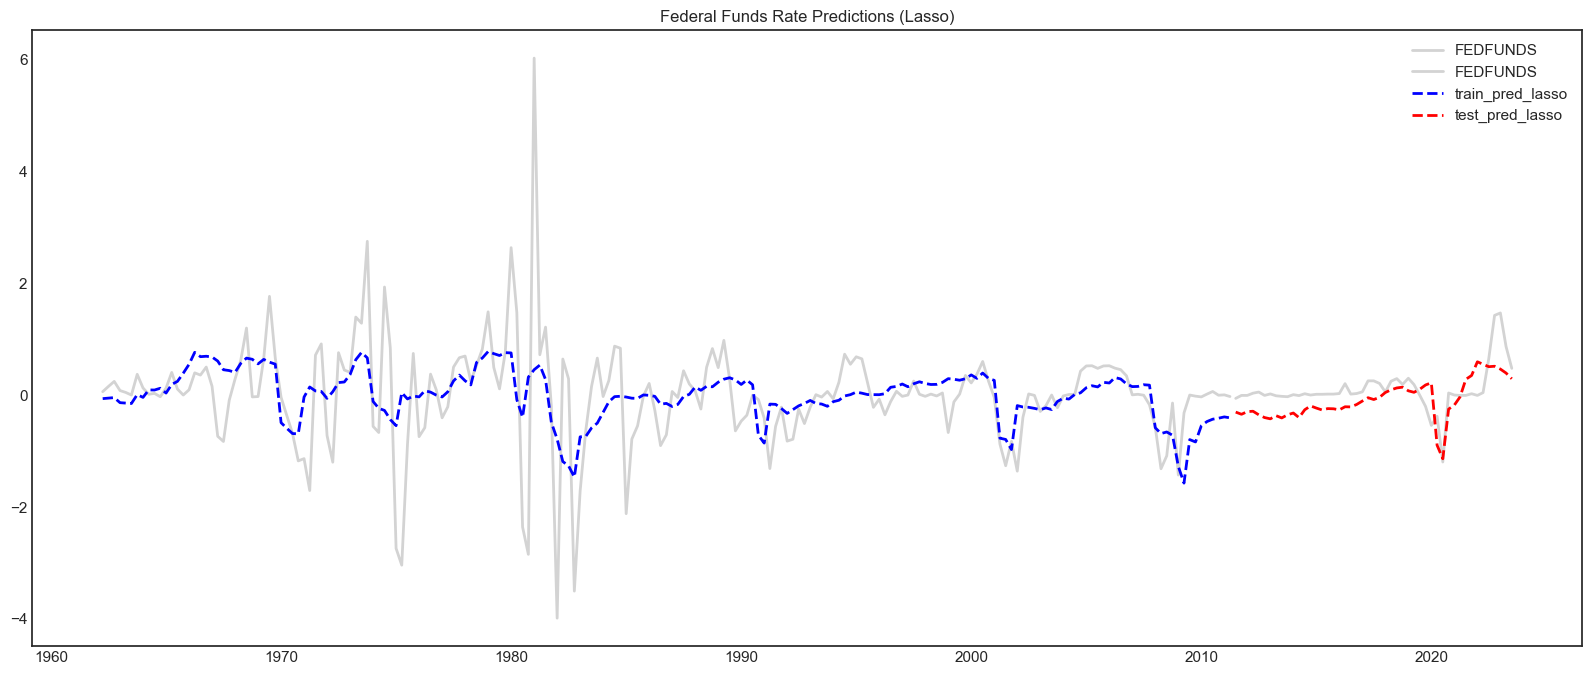

In [2763]:
# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid(False)

# Plot
ax.plot(train_df.index, train_df['FEDFUNDS_diff'], 'lightgray', linewidth=2)
ax.plot(test_df.index, test_df['FEDFUNDS_diff'], 'lightgray', linewidth=2)
ax.plot(train_df.index, train_pred_lasso, color='blue', linestyle='--', linewidth=2)
ax.plot(test_df.index, test_pred_lasso, color='red', linestyle='--', linewidth=2)

ax.legend(["FEDFUNDS", "FEDFUNDS","train_pred_lasso","test_pred_lasso"])
ax.set(title='Federal Funds Rate Predictions (Lasso)');

plt.show()

## Sharpe

In [2764]:
model = cv.best_estimator_.named_steps.model
model

LassoCV(cv=5, max_iter=10000, random_state=12, verbose=0)

In [2765]:
explainer = None
shap_values = None

In [2766]:
try:
    explainer = shap.Explainer(lasso_best, X_test_trf)
    shap_values = explainer(X_test_trf)
except Exception as e:
    print('-- error ')
    print(e)

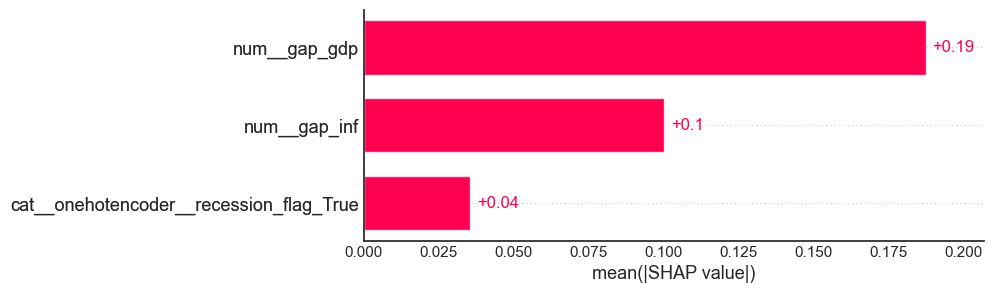

In [2767]:
if (shap_values is not None):
    shap.plots.bar(shap_values, max_display=20)

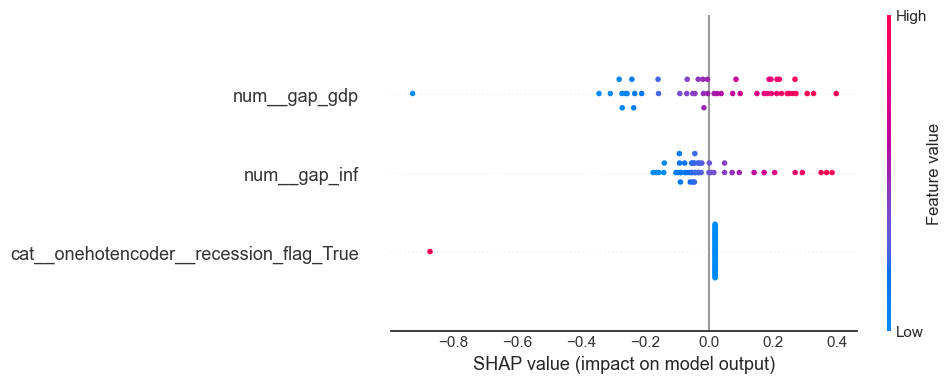

In [2768]:
if (shap_values is not None):
    shap.summary_plot(shap_values, X_test_trf, plot_size=(10,4))

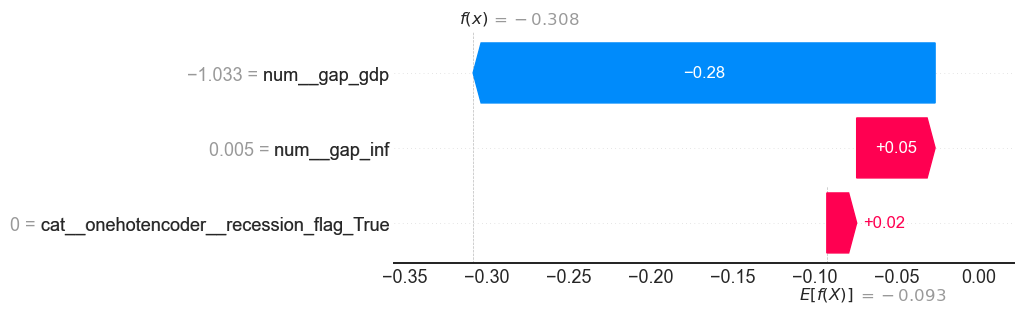

In [2769]:
if (shap_values is not None):
    shap.plots.waterfall(shap_values[0], max_display=20)


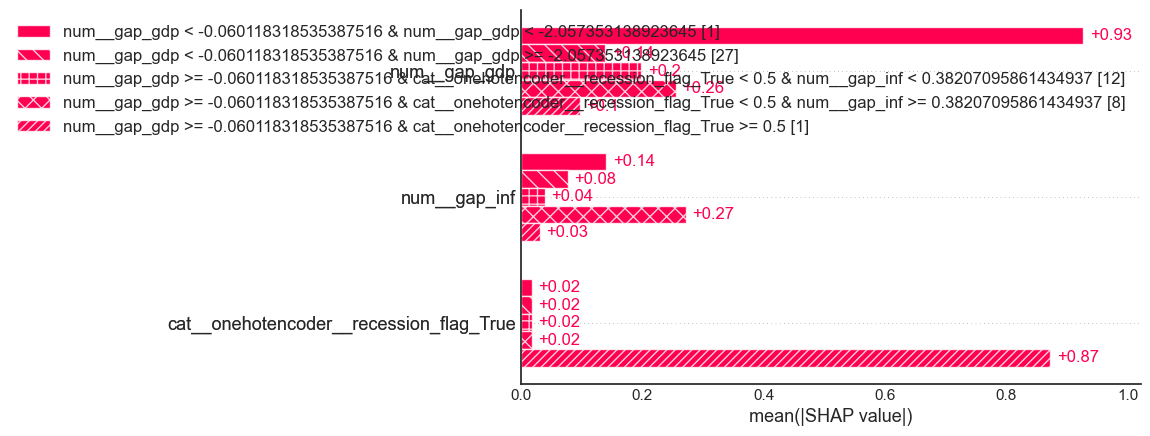

In [2770]:
if (shap_values is not None):
    shap.plots.bar(shap_values.cohorts(5).abs.mean(0),  max_display=10)

In [2771]:
shap.force_plot(shap_values, plot_cmap = "PkYg")

if (shap_values is not None):
    shap.plots.scatter(shap_values[:,"num__gap_ue"])

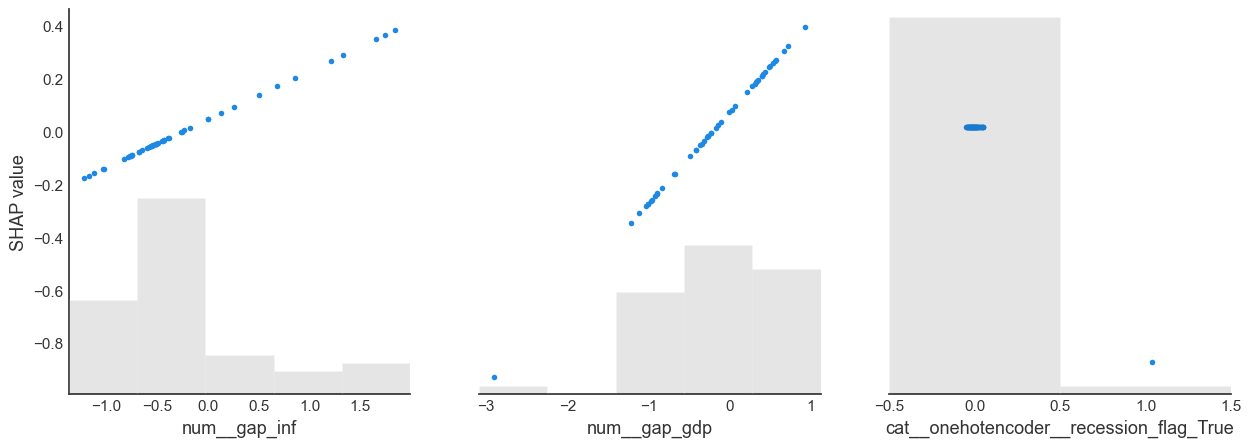

In [2772]:
if (shap_values is not None):
    shap.plots.scatter(shap_values)

# LGBM

In [2773]:
pipe_ltb = Pipeline(
    steps = [ ('preprocessor',preprocessor), ('model',ltb.LGBMRegressor())]
)

param_ltb = {
    'model__n_estimators': randint(100, 300), #[100, 200, 300],
    'model__learning_rate': uniform(0.01, 0.5),  #[0.01, 0.05, 0.1, 0.5],
    'model__max_depth': randint(3, 10),
    'model__num_leaves': randint(3, 60),
    'model__min_data_in_leaf' : randint(10, 20),
    'model__reg_alpha' : uniform(0.01, 0.1), 
    'model__verbose': [-1],
    'model__eval_metric': ['r2_score'],
}


cv = RandomizedSearchCV(estimator = pipe_ltb, 
                        param_distributions = param_ltb,
                        random_state=rand_int, 
                        scoring="r2")

cv.fit(X_train, y_train)
cv_results = cv.cv_results_['mean_test_score']
print('LGBMR', ') Best Accuracy Score:' , cv.best_score_ , 'Parameters: {}' , cv.best_params_)

LGBMR ) Best Accuracy Score: 0.09325975909113986 Parameters: {} {'model__eval_metric': 'r2_score', 'model__learning_rate': 0.08708142118983618, 'model__max_depth': 9, 'model__min_data_in_leaf': 11, 'model__n_estimators': 230, 'model__num_leaves': 6, 'model__reg_alpha': 0.08236018032921474, 'model__verbose': -1}


In [2774]:
cv.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler_num',
                                                                   RobustScaler()),
                                                                  ('imp_num',
                                                                   SimpleImputer())]),
                                                  ['gap_inf', 'gap_gdp']),
                                                 ('cat',
                                                  Pipeline(steps=[('transformer',
                                                                   ColumnTransformer(transformers=[('onehotencoder',
                                                                                                    OneHotEncoder(categories=[[False,
                                                                                                                               True]],
                                                                                                                  drop='first',
                                                                                                                  handle_unknown='ignore',
                                                                                                                  sparse_output=False),
                                                                                                    ['recession_flag'])]))]),
                                                  ['recession_flag'])])),
                ('model',
                 LGBMRegressor(eval_metric='r2_score',
                               learning_rate=0.08708142118983618, max_depth=9,
                               min_data_in_leaf=11, n_estimators=230,
                               num_leaves=6, reg_alpha=0.08236018032921474,
                               verbose=-1))])

In [2775]:
cv.best_estimator_.named_steps.model

LGBMRegressor(eval_metric='r2_score', learning_rate=0.08708142118983618,
              max_depth=9, min_data_in_leaf=11, n_estimators=230, num_leaves=6,
              reg_alpha=0.08236018032921474, verbose=-1)

In [2776]:
train_pred_lgbm = cv.best_estimator_.predict(X_train, pred_contrib=False, raw_score=False)

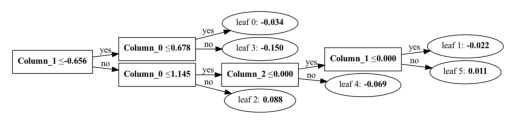

In [2777]:
ltb.plot_tree(cv.best_estimator_.named_steps.model)
plt.show()

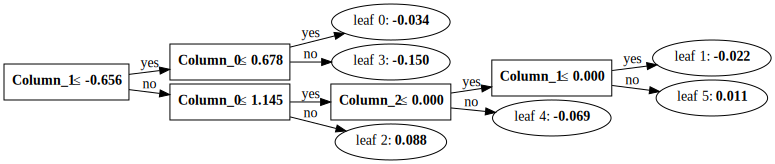

In [2778]:
ltb.create_tree_digraph(cv.best_estimator_.named_steps.model)

In [2779]:
feature_df = pd.DataFrame({'feature_name': cv.best_estimator_.named_steps.preprocessor.get_feature_names_out(),
                           'feature_importance': cv.best_estimator_.named_steps.model.feature_importances_})
feature_df.sort_values(by=['feature_importance'], key=pd.Series.abs , ascending=False , inplace=True)
feature_df

feature_name  feature_importance
0                             num__gap_inf                 636
1                             num__gap_gdp                 472
2  cat__onehotencoder__recession_flag_True                  42

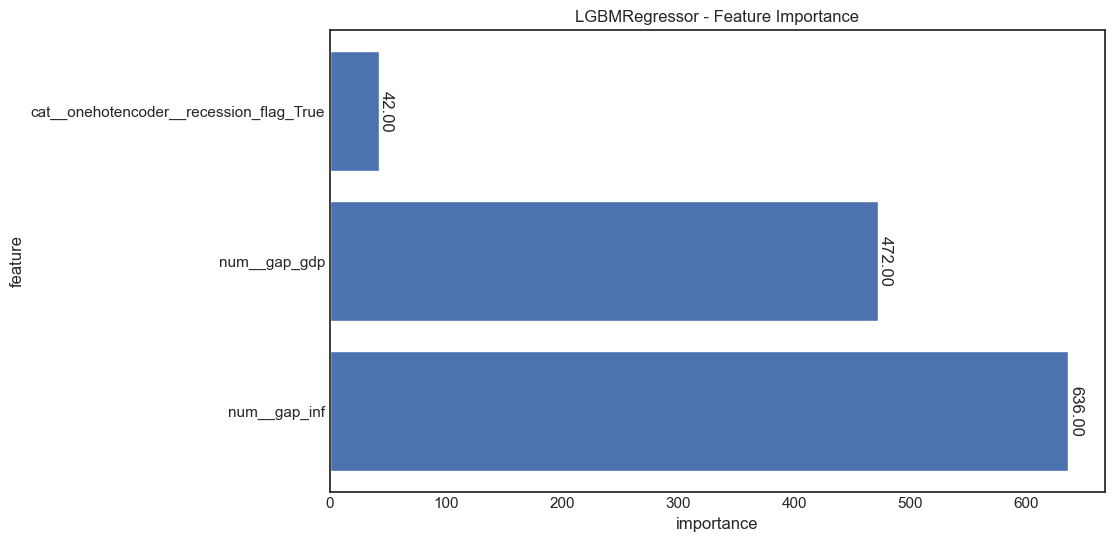

In [2780]:
plt.figure(figsize=(10, 6))

bars = plt.barh(feature_df['feature_name'], feature_df['feature_importance'])
    
# Add vertical labels to the bars
for i, value in enumerate(feature_df['feature_importance']):
    plt.text(value, i, f'{value:.2f}', va='center', ha='left', rotation=-90)

    
plt.xlabel('importance')
plt.ylabel('feature')
plt.title('LGBMRegressor - Feature Importance')
plt.grid(False)
plt.show()

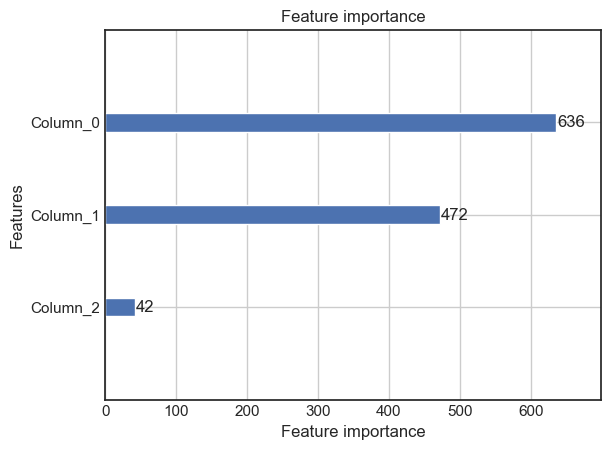

In [2781]:
ltb.plot_importance(cv.best_estimator_.named_steps.model)
plt.show()

In [2782]:
model_stats_df = model_results('lgbm_train', y_train, train_pred_lgbm, X_train.shape[0], X_train.shape[1] , model_stats_df )

## Test

In [2783]:
test_pred_lgbm = cv.best_estimator_.predict(X_test, pred_contrib=False, raw_score=False)
test_pred_lgbm.shape

(49,)

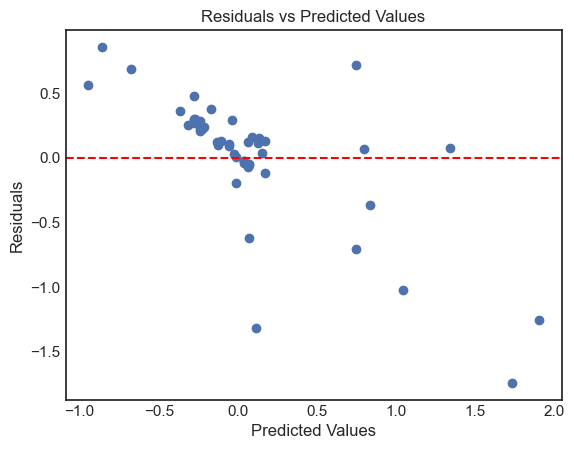

In [2784]:
residuals = y_test - test_pred_lgbm
plt.scatter(test_pred_lgbm, residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')
plt.axhline(y=0, color='red', linestyle='--')  # Add horizontal line at y=0 for reference
plt.show()

In [2785]:
model_stats_df = model_results('lgbm_test', y_test, test_pred_lgbm, X_test.shape[0], X_test.shape[1] , model_stats_df )

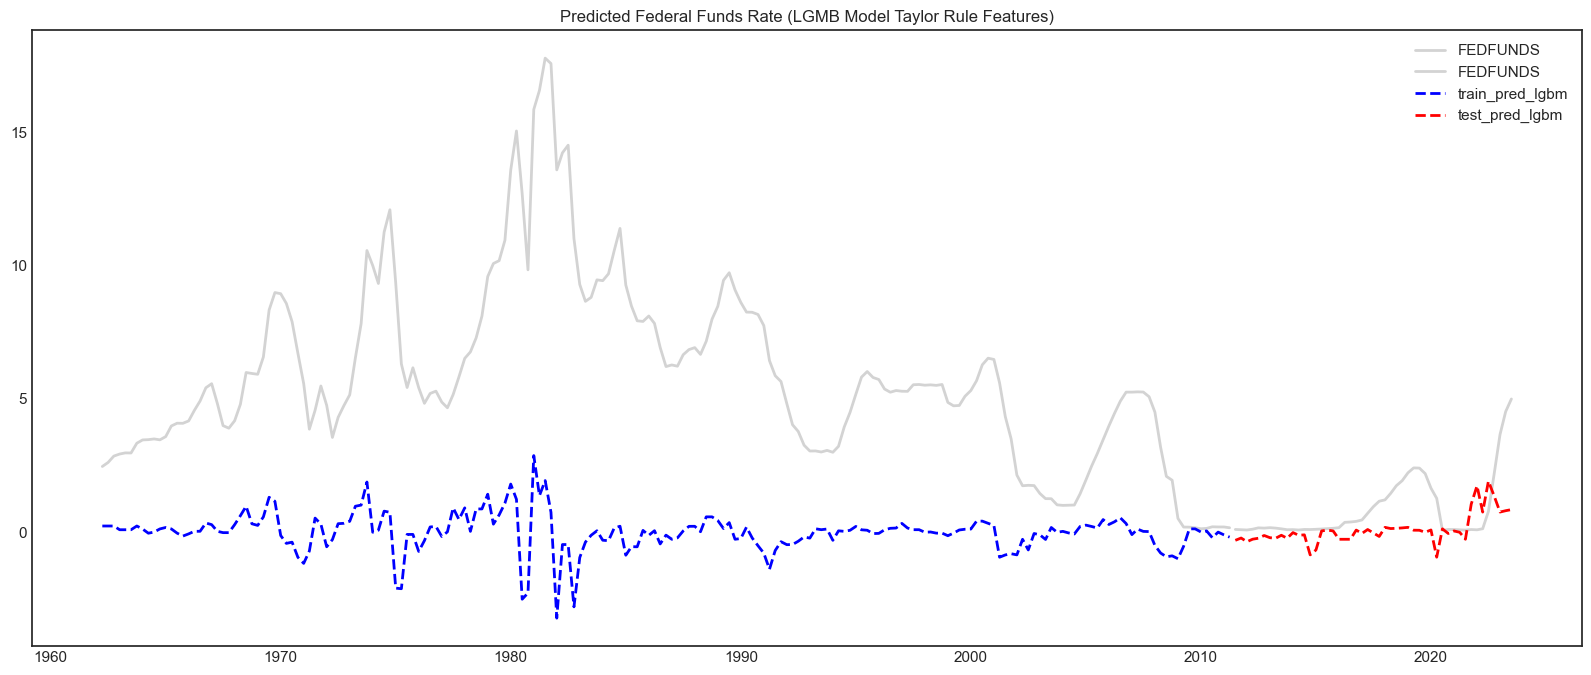

In [2786]:
# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid(False)

# Plot
ax.plot(train_df.index, train_df['FEDFUNDS'], 'lightgray', linewidth=2)
ax.plot(test_df.index, test_df['FEDFUNDS'], 'lightgray', linewidth=2)
ax.plot(X_train.index, train_pred_lgbm, color='blue', linestyle='--', linewidth=2)
ax.plot(X_test.index, test_pred_lgbm, color='red', linestyle='--', linewidth=2)
#ax.fill_between(test_pred_ols.index, test_pred_ols['mean_ci_lower'], test_pred_ols['mean_ci_upper'], alpha=0.20)
#ax.fill_between(test_pred_ols.index, test_pred_ols['obs_ci_lower'], test_pred_ols['obs_ci_upper'], alpha=0.15)

#ax.plot(taylor_df.index, taylor_df['ffef_tr'], 'orange', linestyle='--', linewidth=1)

ax.legend(["FEDFUNDS", "FEDFUNDS","train_pred_lgbm","test_pred_lgbm"])
ax.set(title='Predicted Federal Funds Rate (LGMB Model Taylor Rule Features)');
plt.show()

# Sharpe

In [2787]:
model = cv.best_estimator_.named_steps.model
model

LGBMRegressor(eval_metric='r2_score', learning_rate=0.08708142118983618,
              max_depth=9, min_data_in_leaf=11, n_estimators=230, num_leaves=6,
              reg_alpha=0.08236018032921474, verbose=-1)

In [2788]:
explainer = None
shap_values = None

In [2789]:
try:
    explainer = shap.Explainer(lasso_best, X_test_trf)
    shap_values = explainer(X_test_trf)
except Exception as e:
    print('-- error ')
    print(e)

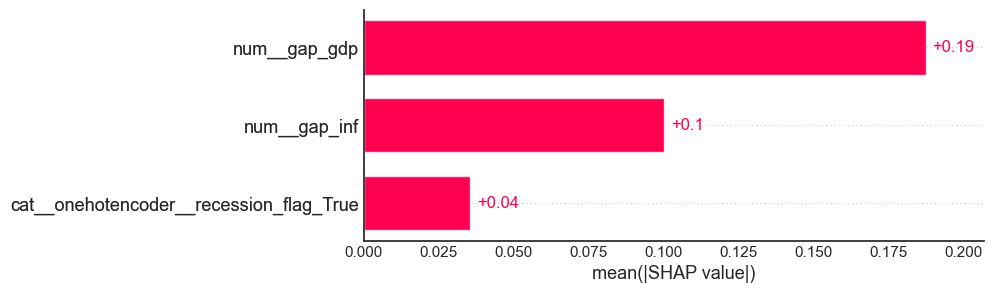

In [2790]:
if (shap_values is not None):
    shap.plots.bar(shap_values, max_display=20)

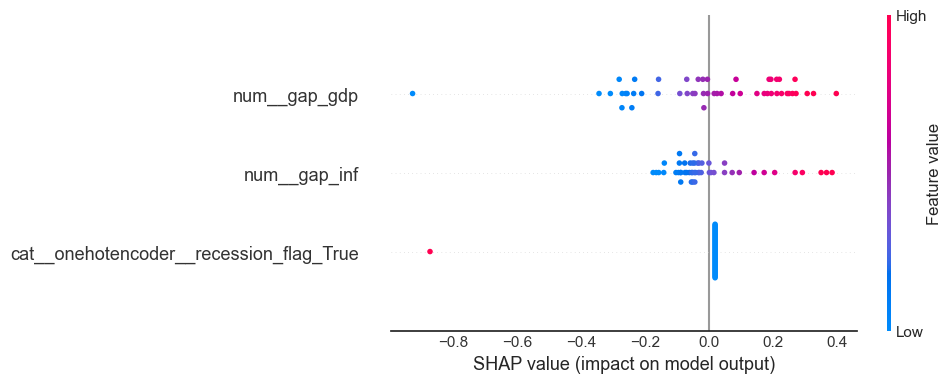

In [2791]:
if (shap_values is not None):
    shap.summary_plot(shap_values, X_test_trf, plot_size=(10,4))

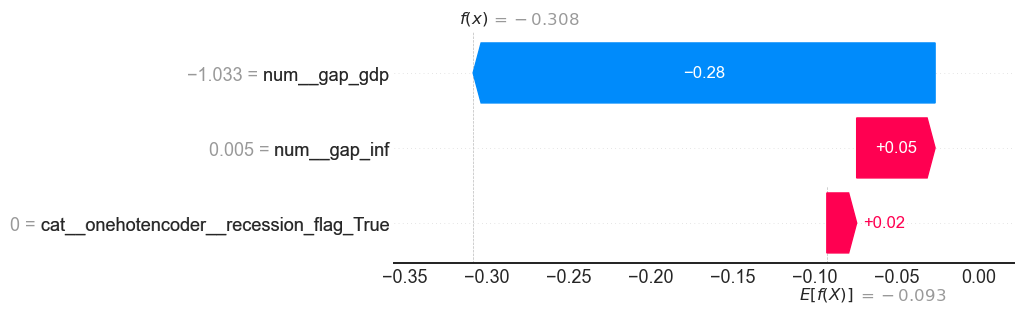

In [2792]:
if (shap_values is not None):
    shap.plots.waterfall(shap_values[0], max_display=20)


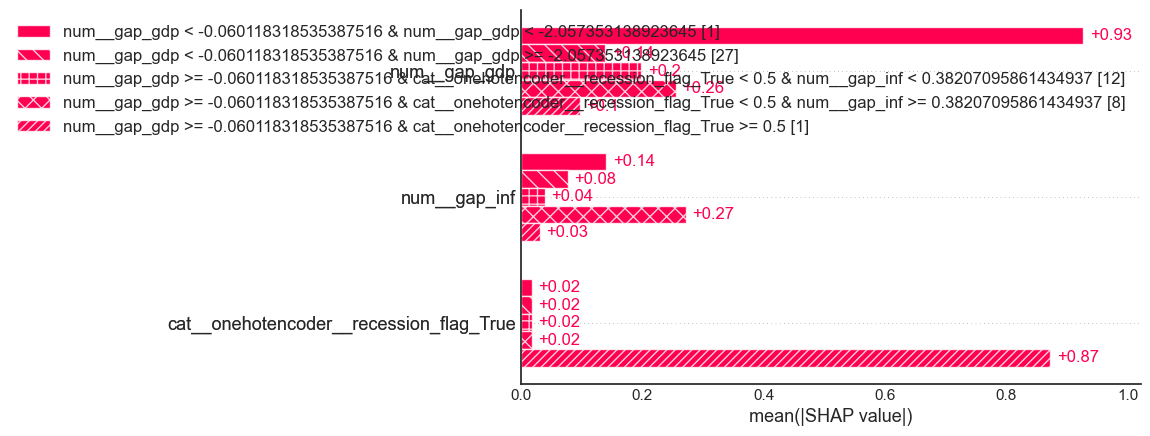

In [2793]:
if (shap_values is not None):
    shap.plots.bar(shap_values.cohorts(5).abs.mean(0),  max_display=10)

In [2794]:
shap.force_plot(shap_values, plot_cmap = "PkYg")

In [2795]:
explainer_tmp = None
shap_values_tmp = None

try:
    explainer_tmp = shap.Explainer(model)
    shap_values_tmp = explainer_tmp.shap_values(X_test_trf)
except Exception as e:
    print('-- error ')
    print(e)

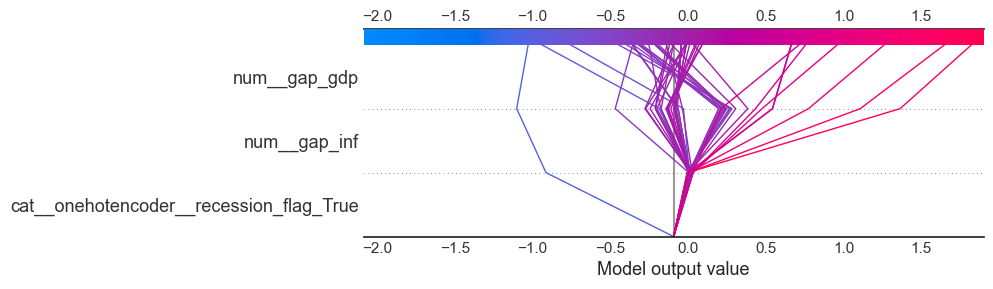

In [2796]:
if (shap_values_tmp is not None):
    expected_value = explainer.expected_value
    shap.decision_plot(expected_value, shap_values_tmp, feature_names, ignore_warnings=True)

In [2797]:
expected_value

-0.09259944154834515

if (shap_values is not None):
    shap.plots.scatter(shap_values[:,"num__FEDFUNDS-1"])

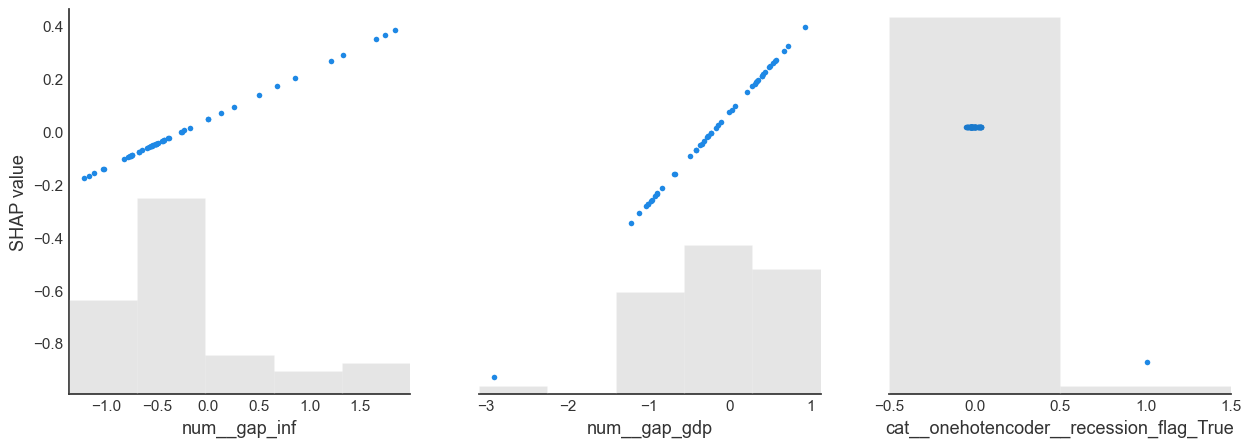

In [2798]:
if (shap_values is not None):
    shap.plots.scatter(shap_values)

# XGB

In [2799]:
pipe_xgb = Pipeline(
    steps = [ ('preprocessor',preprocessor), ('model',xgb.XGBRegressor())]
)

param_xgb = {
    'model__learning_rate': uniform(0.01, 0.5),
    'model__n_estimators': randint(100, 300),
    'model__max_depth': randint(3, 10),
    'model__min_child_weight' : randint(1, 15),
    'model__subsample' : uniform(0.05, 1.0),
    'model__colsample_bytree' : uniform(0.05, 1.0),
    'model__reg_alpha' : uniform(0.01, 0.1), 
    'model__verbose': [-1],
}


cv = RandomizedSearchCV(estimator = pipe_xgb, 
                        param_distributions = param_xgb,
                        random_state=rand_int, 
                        scoring="r2")

cv.fit(X_train, y_train)
cv_results = cv.cv_results_['mean_test_score']
print('XGB', ') Best Accuracy Score:' , cv.best_score_ , 'Parameters: {}' , cv.best_params_)

XGB ) Best Accuracy Score: 0.0577152630124369 Parameters: {} {'model__colsample_bytree': 0.7758614974313065, 'model__learning_rate': 0.017249308005608803, 'model__max_depth': 9, 'model__min_child_weight': 5, 'model__n_estimators': 170, 'model__reg_alpha': 0.060069680454765316, 'model__subsample': 0.8547895388034705, 'model__verbose': -1}


In [2800]:
cv.best_estimator_.named_steps.model.score(X_train_trf, y_train)

0.6939282434823522

In [2801]:
cv.best_estimator_.named_steps.model

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7758614974313065, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.017249308005608803, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=9, max_leaves=None,
             min_child_weight=5, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=170, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [2802]:
train_pred_xgb = cv.best_estimator_.predict(X_train)

In [2803]:
fig, ax = plt.subplots(figsize=(25,10))
#plt.figure(figsize=(12,12))
#xgb.plot_tree(xgb_model, ax=ax)
xgb.plot_tree(cv.best_estimator_.named_steps.model, ax=ax,fontsize=10)

fig.set_size_inches(150, 100)
fig.savefig('tree.png')

plt.show()

In [2804]:
cv

RandomizedSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('scaler_num',
                                                                                                RobustScaler()),
                                                                                               ('imp_num',
                                                                                                SimpleImputer())]),
                                                                               ['gap_inf',
                                                                                'gap_gdp']),
                                                                              ('cat',
                                                                               Pipeline(steps=[('transformer',
                                                                                                ColumnTransformer(transformers=[('onehotencoder',
                                                                                                                                 OneHotEncoder(categories=[[False,
                                                                                                                                                            True]],
                                                                                                                                               drop='first',
                                                                                                                                               handle_unkn...
                                        'model__min_child_weight': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x2a05b6200>,
                                        'model__n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x2a05b52a0>,
                                        'model__reg_alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x2a05b6920>,
                                        'model__subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x2a05b6710>,
                                        'model__verbose': [-1]},
                   random_state=12, scoring='r2')

In [2805]:
feature_df = pd.DataFrame({'feature_name': cv.best_estimator_.feature_names_in_,
                           'feature_importance': cv.best_estimator_.named_steps.model.feature_importances_})

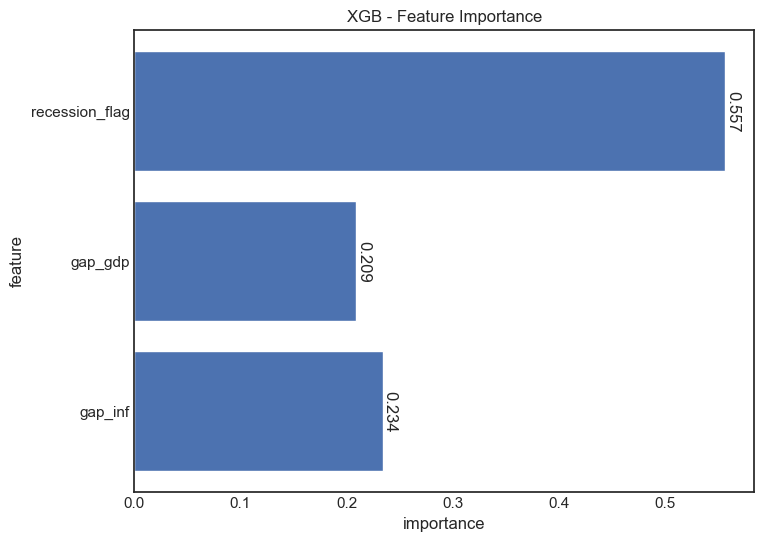

In [2806]:
plt.figure(figsize=(8, 6))

bars = plt.barh(feature_df['feature_name'], feature_df['feature_importance'])
    
# Add vertical labels to the bars
for i, value in enumerate(feature_df['feature_importance']):
    plt.text(value, i, f'{value:.3f}', va='center', ha='left', rotation=-90)

    
plt.xlabel('importance')
plt.ylabel('feature')
plt.title('XGB - Feature Importance')
plt.grid(False)
plt.show()

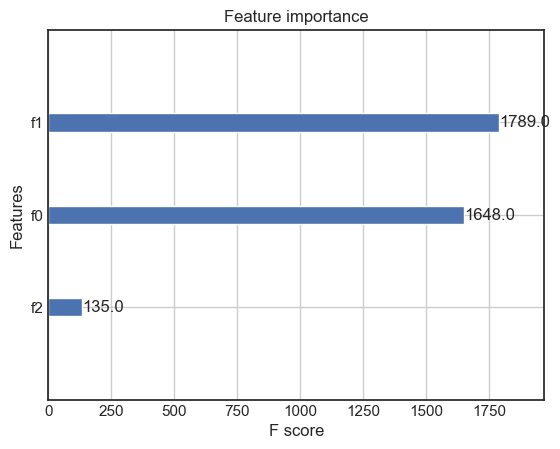

In [2807]:
xgb.plot_importance(cv.best_estimator_.named_steps.model)
plt.show()

In [2808]:
model_stats_df = model_results('xgb_train', y_train, train_pred_xgb, X_train.shape[0], X_train.shape[1] , model_stats_df )

## Test

In [2809]:
test_pred_xgb = cv.best_estimator_.predict(X_test)
print('test_pred_xbg: ', test_pred_xgb.shape)

test_pred_xbg:  (49,)


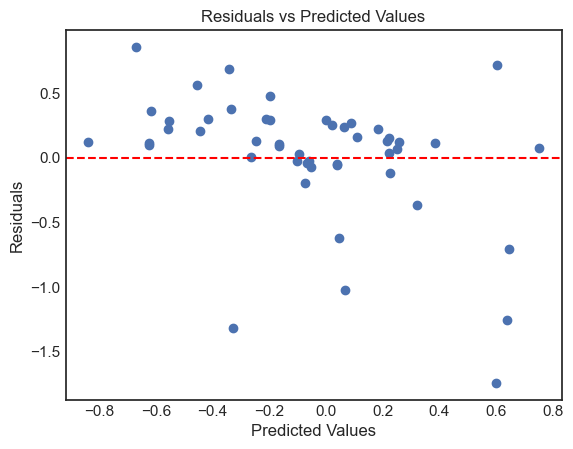

In [2810]:
residuals = y_test - test_pred_lgbm
plt.scatter(test_pred_xgb, residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')
plt.axhline(y=0, color='red', linestyle='--')  # Add horizontal line at y=0 for reference
plt.show()

In [2811]:
model_stats_df = model_results('xgb_test', y_test, test_pred_lgbm, X_test.shape[0], X_test.shape[1] , model_stats_df )

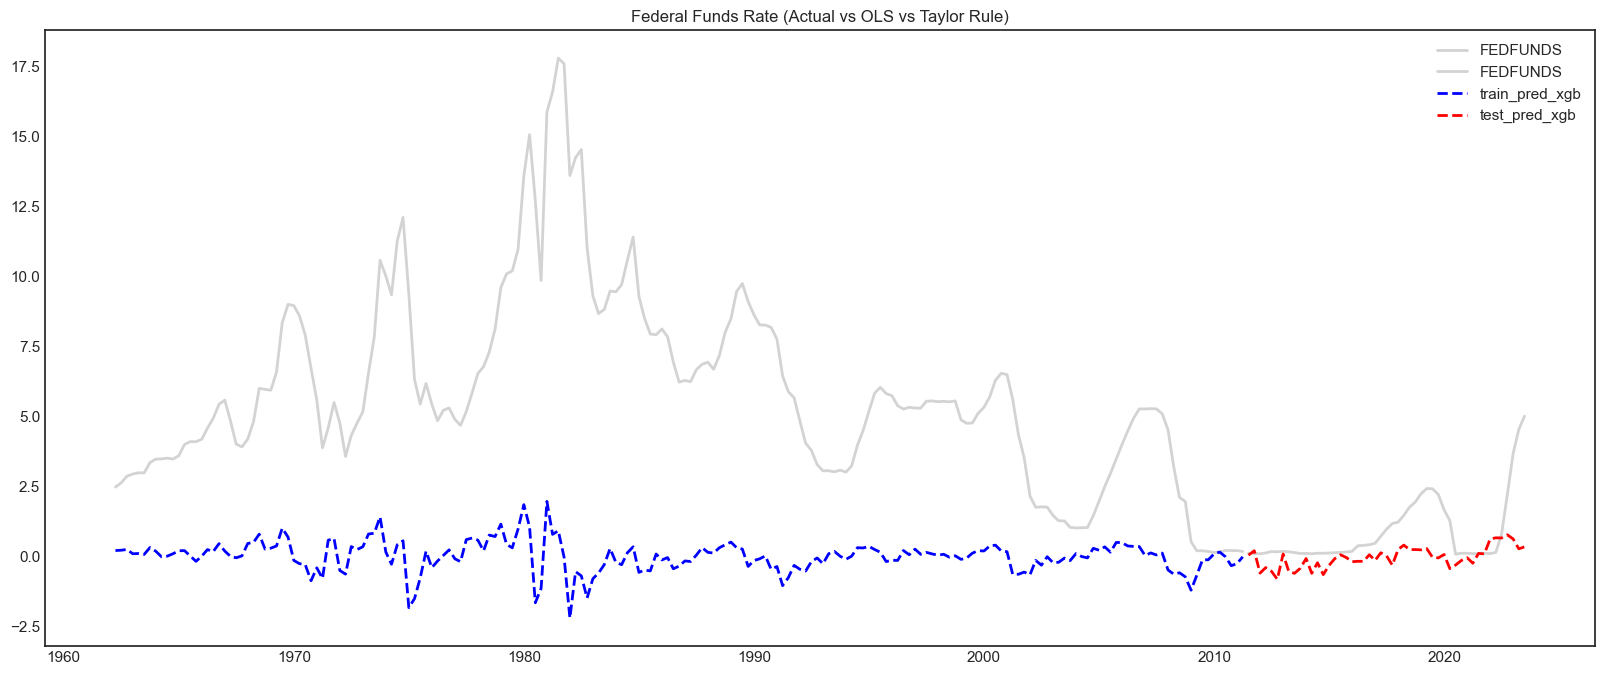

In [2812]:
# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid(False)

# Plot
ax.plot(train_df.index, train_df['FEDFUNDS'], 'lightgray', linewidth=2)
ax.plot(test_df.index, test_df['FEDFUNDS'], 'lightgray', linewidth=2)
ax.plot(X_train.index, train_pred_xgb, color='blue', linestyle='--', linewidth=2)
ax.plot(X_test.index, test_pred_xgb, color='red', linestyle='--', linewidth=2)
#ax.fill_between(test_pred_ols.index, test_pred_ols['mean_ci_lower'], test_pred_ols['mean_ci_upper'], alpha=0.20)
#ax.fill_between(test_pred_ols.index, test_pred_ols['obs_ci_lower'], test_pred_ols['obs_ci_upper'], alpha=0.15)

#ax.plot(taylor_df.index, taylor_df['ffef_tr'], 'orange', linestyle='--', linewidth=1)

ax.legend(["FEDFUNDS", "FEDFUNDS","train_pred_xgb","test_pred_xgb"])
ax.set(title='Federal Funds Rate (Actual vs OLS vs Taylor Rule)');
plt.show()

# AdaBoostRegressor

In [2813]:
pipe_ada = Pipeline(
    steps = [ ('preprocessor',preprocessor), ('model',AdaBoostRegressor())]
)

param_ada = {
    'model__learning_rate' : [0.01, 0.1, 0.5, 1.0],
    'model__n_estimators' : [50, 100, 150, 200, 250],
    'model__loss' : ["linear","exponential"],  
}


cv = RandomizedSearchCV(estimator = pipe_ada, 
                        param_distributions = param_ada,
                        random_state=rand_int, 
                        scoring="r2")

cv.fit(X_train, y_train)
cv_results = cv.cv_results_['mean_test_score']
print('ADA', ') Best Accuracy Score:' , cv.best_score_ , 'Parameters: {}' , cv.best_params_)

ADA ) Best Accuracy Score: 0.08277889097998685 Parameters: {} {'model__n_estimators': 250, 'model__loss': 'exponential', 'model__learning_rate': 0.01}


In [2814]:
cv.best_estimator_.named_steps.model.score(X_train_trf, y_train)

0.6575658731096368

In [2815]:
cv.best_estimator_.named_steps.model

AdaBoostRegressor(learning_rate=0.01, loss='exponential', n_estimators=250)

In [2816]:
feature_df = pd.DataFrame({'feature_name': cv.best_estimator_.feature_names_in_,
                           'feature_importance': cv.best_estimator_.named_steps.model.feature_importances_})

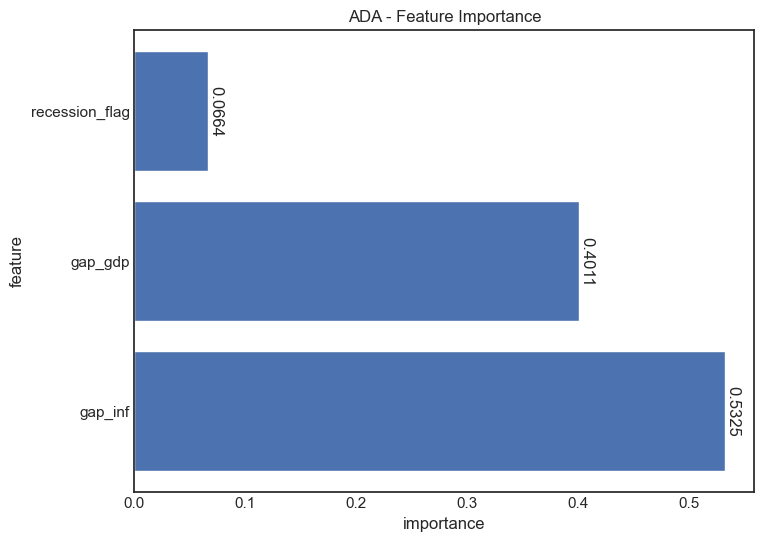

In [2817]:
plt.figure(figsize=(8, 6))

bars = plt.barh(feature_df['feature_name'], feature_df['feature_importance'])
    
# Add vertical labels to the bars
for i, value in enumerate(feature_df['feature_importance']):
    plt.text(value, i, f'{value:.4f}', va='center', ha='left', rotation=-90)

    
plt.xlabel('importance')
plt.ylabel('feature')
plt.title('ADA - Feature Importance')
plt.grid(False)
plt.show()

In [2818]:
train_pred_ada = cv.best_estimator_.predict(X_train)
model_stats_df = model_results('ada_test', y_train, train_pred_ada, X_train.shape[0], X_train.shape[1] , model_stats_df )

In [2819]:
test_pred_ada = cv.best_estimator_.predict(X_test)
model_stats_df = model_results('ada_test', y_test, test_pred_ada, X_test.shape[0], X_test.shape[1] , model_stats_df )

# tsa.SARIMAX

In [2820]:
#model = sm.tsa.SARIMAX(y_train, order=(1,0,0), seasonal_order=(0, 0, 0, 4),enforce_stationarity=True, exog=X_train_trf)
model = sm.tsa.SARIMAX(y_train, order=(1,0,0), enforce_stationarity=True, exog=X_train_trf)
result_model = model.fit(disp=False)

result_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:          FEDFUNDS_diff   No. Observations:                  197
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -250.246
Date:                Tue, 28 Nov 2023   AIC                            510.492
Time:                        00:36:48   BIC                            526.908
Sample:                    03-31-1962   HQIC                           517.137
                         - 03-31-2011                                         
Covariance Type:                  opg                                         
===========================================================================================================
                                              coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
num__gap_inf                                0.1885      0.046      4.108      0.000       0.099       0.278
num__gap_gdp                                0.3558      0.089      3.990      0.000       0.181       0.531
cat__onehotencoder__recession_flag_True    -0.8396      0.181     -4.648      0.000      -1.194      -0.486
ar.L1                                       0.0771      0.059      1.311      0.190      -0.038       0.192
sigma2                                      0.7428      0.040     18.545      0.000       0.664       0.821
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):              1185.32
Prob(Q):                              0.79   Prob(JB):                         0.00
Heteroskedasticity (H):               0.24   Skew:                             0.79
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.91
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [2821]:
train_result = result_model.get_prediction(start=-len(X_train_trf), dynamic=True)

In [2822]:
train_pred_SARIM = train_result.summary_frame()
train_pred_SARIM

FEDFUNDS_diff      mean   mean_se  mean_ci_lower  mean_ci_upper
1962-03-31    -0.119207  0.864429      -1.813456       1.575041
1962-06-30    -0.109836  0.864429      -1.804085       1.584413
1962-09-30    -0.100638  0.864429      -1.794886       1.593611
1962-12-31    -0.193721  0.864429      -1.887970       1.500528
1963-03-31    -0.200336  0.864429      -1.894585       1.493912
...                 ...       ...            ...            ...
2010-03-31    -0.540602  0.864429      -2.234851       1.153647
2010-06-30    -0.497398  0.864429      -2.191647       1.196851
2010-09-30    -0.479425  0.864429      -2.173674       1.214824
2010-12-31    -0.455405  0.864429      -2.149654       1.238844
2011-03-31    -0.472546  0.864429      -2.166795       1.221703

[197 rows x 4 columns]

## Test

In [2823]:
X_test_trf = t_fit.transform(X_test)
X_test_trf = pd.DataFrame(X_test_trf)
X_test_trf.columns = t_fit.get_feature_names_out()
X_test_trf['DATE'] = test_df.index
X_test_trf.set_index('DATE', inplace=True)


y_test = test_df['FEDFUNDS']

In [2824]:
s_idx = len(X_train_trf)
e_idx = s_idx + len(X_test_trf) - 1

test_result = result_model.get_prediction(start=s_idx, end=e_idx, exog=X_test_trf, dynamic=True)

In [2825]:
test_pred_SARIM = test_result.summary_frame()
test_pred_SARIM.shape

(49, 4)

In [2826]:
predict_ci = test_result.conf_int(alpha=0.5)
predict_ci.head()

lower FEDFUNDS_diff  upper FEDFUNDS_diff
2011-06-30            -0.913917             0.248706
2011-09-30            -0.987428             0.178648
2011-12-31            -0.940843             0.225253
2012-03-31            -0.934293             0.231803
2012-06-30            -0.999995             0.166102

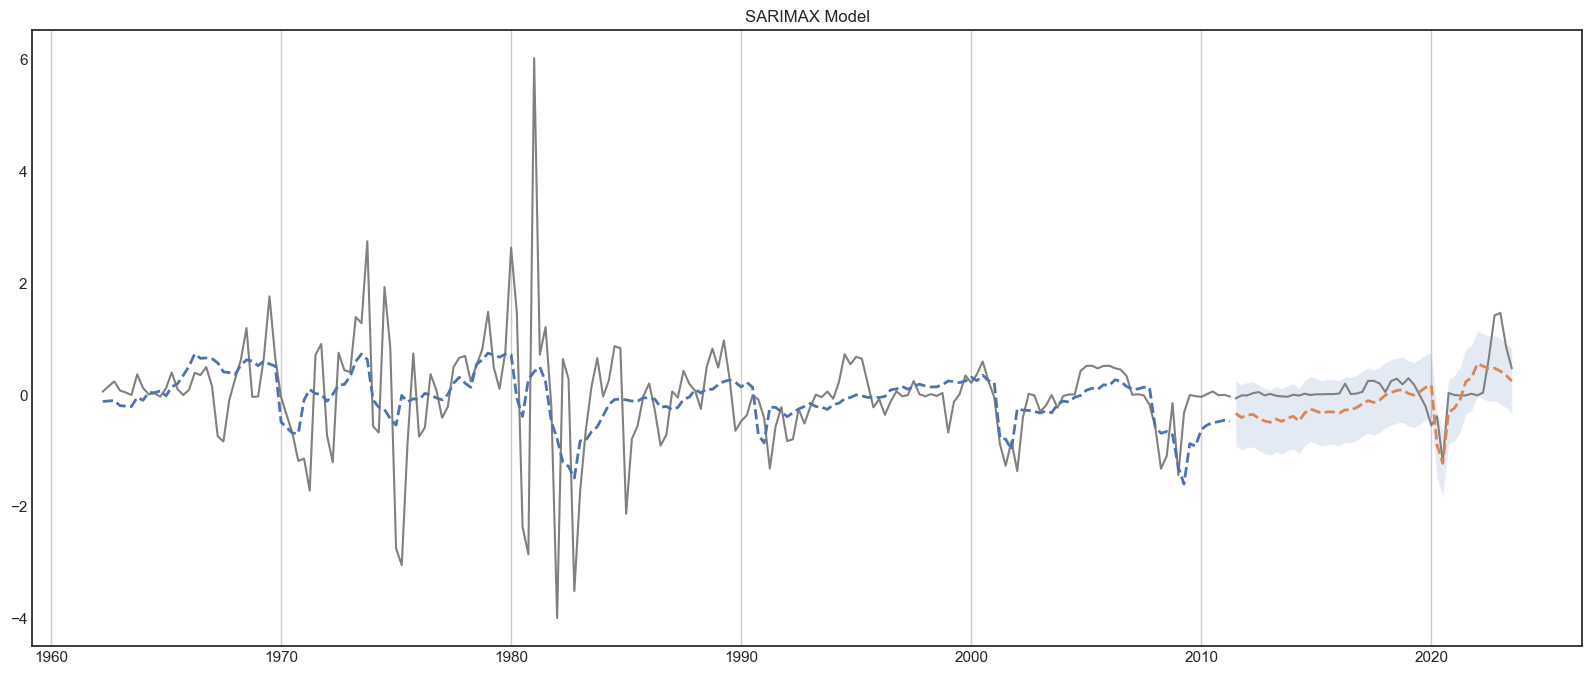

In [2827]:
# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid()

# Plot
ax.plot(train_df.index, train_df['FEDFUNDS_diff'], 'gray')
ax.plot(test_df.index, test_df['FEDFUNDS_diff'], 'gray')
ax.plot(train_pred_SARIM.index, train_pred_SARIM['mean'], linestyle='--', linewidth=2)
ax.plot(test_pred_SARIM.index, test_pred_SARIM['mean'], linestyle='--', linewidth=2)
ax.fill_between(test_pred_SARIM.index, predict_ci['lower FEDFUNDS_diff'], predict_ci['upper FEDFUNDS_diff'], alpha=0.15)

ax.set(title='SARIMAX Model');

In [2828]:
model_stats_df = model_results('SARIMAX_train',y_train, train_pred_SARIM['mean'], X_train.shape[0], X_train.shape[1] , model_stats_df )
model_stats_df = model_results('SARIMAX_test', y_test, test_pred_SARIM['mean'], X_test.shape[0], X_test.shape[1] , model_stats_df )


# auto arima

In [2829]:
import pmdarima as pm

In [2830]:
# Initiate and Fit Model
arima_model = pm.auto_arima(y = y_train, 
                            X = X_train_trf,
                            test='adf', 
                            seasonal=True, 
                            error_action='ignore',  
                            suppress_warnings=True,
                            stepwise=True, trace=True)



Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=500.342, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=511.140, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=512.066, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=510.842, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=509.663, Time=0.02 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=498.536, Time=0.04 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=497.129, Time=0.04 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=498.321, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=502.462, Time=0.04 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=499.330, Time=0.05 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=495.739, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=509.179, Time=0.02 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=497.172, Time=0.03 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=496.959, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=500.8

In [2831]:
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  197
Model:               SARIMAX(0, 0, 2)   Log Likelihood                -241.869
Date:                Tue, 28 Nov 2023   AIC                            495.739
Time:                        00:36:49   BIC                            515.438
Sample:                    03-31-1962   HQIC                           503.713
                         - 03-31-2011                                         
Covariance Type:                  opg                                         
===========================================================================================================
                                              coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
num__gap_inf                                0.1927      0.035      5.548      0.000       0.125       0.261
num__gap_gdp                                0.3126      0.075      4.160      0.000       0.165       0.460
cat__onehotencoder__recession_flag_True    -0.8257      0.156     -5.301      0.000      -1.131      -0.520
ma.L1                                       0.1545      0.055      2.795      0.005       0.046       0.263
ma.L2                                      -0.2799      0.038     -7.277      0.000      -0.355      -0.205
sigma2                                      0.6815      0.042     16.101      0.000       0.599       0.764
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):               913.99
Prob(Q):                              0.79   Prob(JB):                         0.00
Heteroskedasticity (H):               0.33   Skew:                             1.12
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.31
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [2832]:
predict, confint = arima_model.predict_in_sample(X=X_train_trf, return_conf_int=True)
train_pred_pmdarima = pd.DataFrame(predict)
train_pred_pmdarima.columns = ['mean']
train_pred_pmdarima['lower'] = confint[:,0]
train_pred_pmdarima['upper'] = confint[:,1]
train_pred_pmdarima.shape

(197, 3)

In [2833]:
forecast, confint = arima_model.predict(len(y_test) , X=X_test_trf, return_conf_int=True)
test_pred_pmdarima = pd.DataFrame(forecast)
test_pred_pmdarima.columns = ['mean']
test_pred_pmdarima['lower'] = confint[:,0]
test_pred_pmdarima['upper'] = confint[:,1]
test_pred_pmdarima.shape

(49, 3)

In [2834]:
model_stats_df = model_results('pmdarima_train',y_train, train_pred_pmdarima['mean'], X_train.shape[0], X_train.shape[1] , model_stats_df )
model_stats_df = model_results('pmdarima_test', y_test, test_pred_pmdarima['mean'], X_test.shape[0], X_test.shape[1] , model_stats_df )

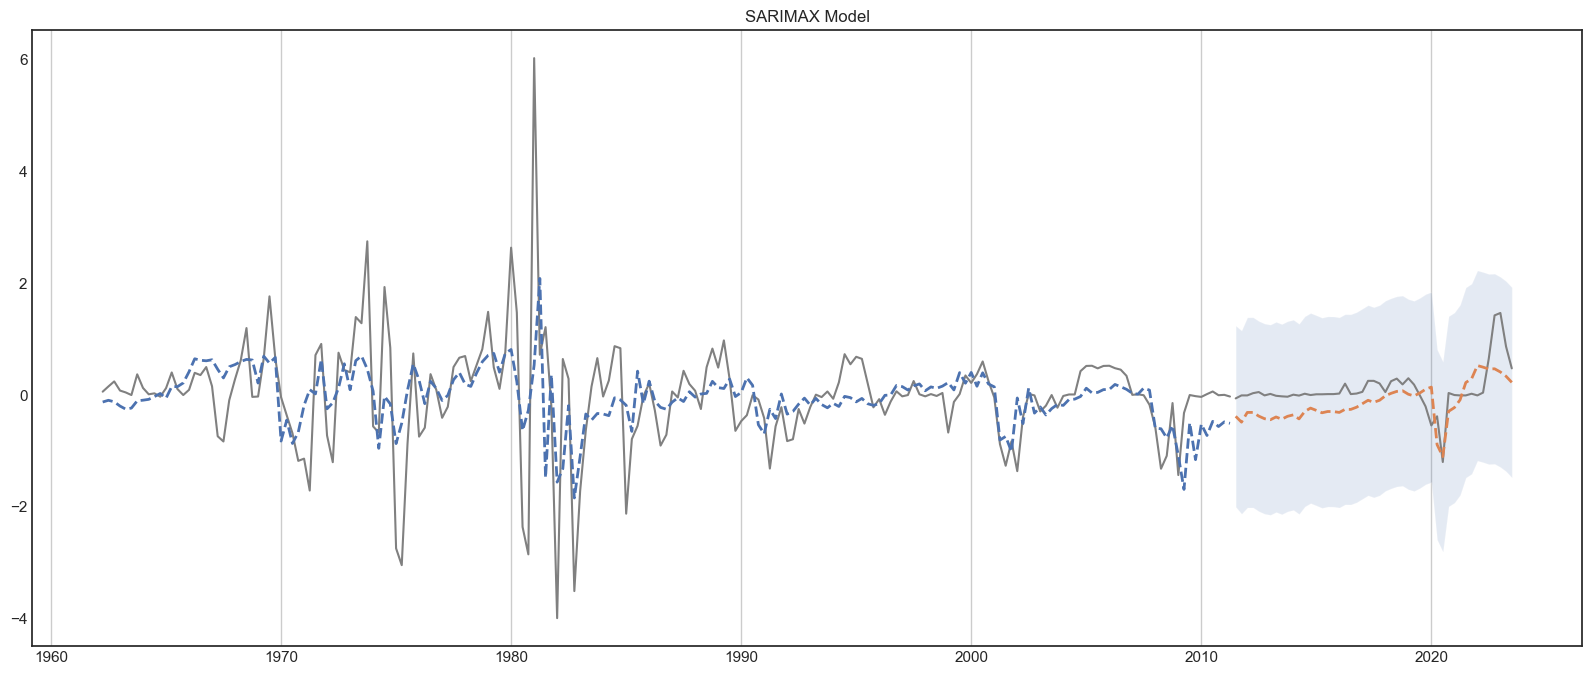

In [2835]:
# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid()

# Plot
ax.plot(train_df.index, train_df['FEDFUNDS_diff'], 'gray')
ax.plot(test_df.index, test_df['FEDFUNDS_diff'], 'gray')
ax.plot(train_pred_pmdarima.index, train_pred_pmdarima['mean'], linestyle='--', linewidth=2)
ax.plot(test_pred_pmdarima.index, test_pred_pmdarima['mean'], linestyle='--', linewidth=2)
ax.fill_between(test_pred_pmdarima.index, test_pred_pmdarima['lower'], test_pred_pmdarima['upper'], alpha=0.15)

ax.set(title='SARIMAX Model');

# Result

In [2836]:
model_stats_df

name     r_sq  adj_r_sq     mse    rmse
0    ffef_tr_train   0.0328    0.0279  0.9061  0.9519
1     ffef_tr_test -13.6332  -13.9446  2.2484  1.4995
2   ffef_tr2_train  -0.3337   -0.3406  1.2494  1.1178
3    ffef_tr2_test   0.5059    0.4954  0.0759  0.2755
4      Naive_train  -0.0001   -0.0001  0.9369  0.9680
5       Naive_test  -0.0633   -0.0633  0.1634  0.4042
6        ols_train   0.2045    0.1963  0.7453  0.8633
7         ols_test   0.1064    0.0675  0.1373  0.3705
8        glm_train   0.0210    0.0109  0.9172  0.9577
9         glm_test  -0.1173   -0.1659  0.1717  0.4143
10     lasso_train   0.2045    0.1963  0.7453  0.8633
11      lasso_test   0.1072    0.0684  0.1372  0.3704
12      lgbm_train   0.7832    0.7809  0.2031  0.4507
13       lgbm_test  -0.5848   -0.6537  0.2435  0.4935
14       xgb_train   0.6939    0.6908  0.2867  0.5355
15        xgb_test  -0.5848   -0.6537  0.2435  0.4935
16        ada_test   0.6576    0.6540  0.3208  0.5664
17        ada_test   0.4091    0.3834  0.0908  0.3013
18   SARIMAX_train   0.2023    0.1941  0.7473  0.8645
19    SARIMAX_test  -0.5016   -0.5669  2.0821  1.4429
20  pmdarima_train   0.2724    0.2649  0.6816  0.8256
21   pmdarima_test  -0.5071   -0.5726  2.0896  1.4455